Import library penting

In [50]:
import pandas as pd
import json
import folium
import numpy as np
import math
import json
from collections import OrderedDict
from shapely.geometry import Point, LineString
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# Analisis Data dan Prediksi Estimated Time Arrival (RTA)  

*Notebook Analisis Komprehensif*

---

## 1. Latar Belakang dan Tujuan

Pada kompetisi data science ini, saya diberikan data pergerakan kendaraan (log GPS) di area kampus Universitas Indonesia dengan rute tertentu (disebut Track "red" dan "blue"). Analisis ini dilakukan untuk memahami karakteristik data tersebut sebelum pemodelan lebih lanjut. Dengan melakukan exploratory data analysis (EDA) dan feature engineering (FE), saya dapat:

- Memahami Pola Data: Mengetahui distribusi nilai kecepatan, sebaran lokasi (latitude, longitude), serta pola waktu perjalanan.
- Mengidentifikasi Masalah Data: Mendeteksi adanya outlier (nilai anomali seperti kecepatan yang tidak realistis), data hilang, atau inkonsistensi yang dapat memengaruhi model.
- Menentukan Strategi Fitur: Merancang dan menjustifikasi transformasi fitur yang akan digunakan pada model (misalnya menghitung jarak tempuh, durasi berhenti, dll) guna meningkatkan akurasi prediksi.
- 
Tujuan akhir dari eksplorasi ini adalah mendapatkan insight mendalam tentang data dan menyiapkan fitur-fitur terbaik untuk model kompetisi, sehingga model dapat memprediksi target (baik klasifikasi rute maupun prediksi waktu/tempuh) dengan lebih baik. Insight yang diperoleh juga akan digunakan untuk memberikan saran perbaikan ke depan.

---

*Catatan:* Pastikan semua library dan versi yang digunakan tercantum pada file `requirements.txt` untuk memastikan reproducibility. Gunakan konstanta random_state yang konsisten di seluruh notebook.

---



## 2. Analisis Data Eksploratori (EDA)

### Memuat Data dan Struktur Data

Di bagian ini, saya memuat data dari file CSV dan JSON, menampilkan informasi dasar, serta memeriksa nilai yang hilang dan tipe data tiap kolom.

In [ ]:
train_df = pd.read_csv('dataset/public/train.csv')
test_df = pd.read_csv("dataset/public/test.csv")

with open('dataset/public/routes.json') as f:
    routes = json.load(f)
with open('dataset/public/jalanraya_ui_flowcoord.json') as f:
    flowcoord = json.load(f)

In [52]:
# Tampilkan dimensi data dan beberapa baris awal
print("Dimensi data train:", train.shape)
print("Dimensi data test:", test.shape)
train.head()

Dimensi data train: (37391, 6)
Dimensi data test: (2311, 6)


,imei,ts,lat,lon,color,speed
0,200676,2024-09-14 07:03:42+07:00,-6.348028,106.828020,red,21
1,200676,2024-09-14 07:04:07+07:00,-6.348349,106.829501,red,17
2,200676,2024-09-14 07:04:59+07:00,-6.348961,106.831840,red,36
3,200676,2024-09-14 07:05:04+07:00,-6.349296,106.831973,red,22
4,200676,2024-09-14 07:05:45+07:00,-6.351046,106.831630,red,0


In [53]:
print(train.info())
display(train.head())
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37391 entries, 0 to 37390
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   imei    37391 non-null  int64  
 1   ts      37391 non-null  object 
 2   lat     37391 non-null  float64
 3   lon     37391 non-null  float64
 4   color   37391 non-null  object 
 5   speed   37391 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.7+ MB
None


,imei,ts,lat,lon,color,speed
0,200676,2024-09-14 07:03:42+07:00,-6.348028,106.828020,red,21
1,200676,2024-09-14 07:04:07+07:00,-6.348349,106.829501,red,17
2,200676,2024-09-14 07:04:59+07:00,-6.348961,106.831840,red,36
3,200676,2024-09-14 07:05:04+07:00,-6.349296,106.831973,red,22
4,200676,2024-09-14 07:05:45+07:00,-6.351046,106.831630,red,0


,Id,ts,lat,lon,color,speed
0,0,2024-09-27 07:02:44+07:00,-6.361136,106.831646,red,0
1,1,2024-09-27 07:02:49+07:00,-6.361136,106.831646,red,0
2,2,2024-09-27 07:03:00+07:00,-6.361136,106.831646,red,0
3,3,2024-09-27 07:04:30+07:00,-6.365393,106.832178,red,18
4,4,2024-09-27 07:05:40+07:00,-6.368206,106.831718,red,0


#### Penjelasan:

- Train terdiri dari `37391` baris dan `6` kolom: `imei`, `ts`, `lat`, `lon`, `color`, dan `speed`.
- Test terdiri dari `2311` baris dan `6` kolom: `Id`, `ts`, `lat`, `lon`, `color`, dan `speed`.
- Kolom `imei` adalah ID perangkat/kendaraan, sedangkan pada test digantikan oleh `Id` (indeks unik tiap entri, tanpa info perangkat).
- Kolom `ts` (timestamp) bertipe datetime string (format UTC+7), `lat` dan `lon` adalah koordinat geografis (latitude, longitude), `color` adalah kategori rute (`red` atau `blue`), dan `speed` adalah kecepatan kendaraan (diasumsikan km/jam).
- Tidak ada nilai kosong pada dataset (setiap kolom terisi lengkap).

Sekilas, data train ini mungkin mampu menyebabkan leakage (dikarenakan ada yang bersinggungan dengan data test), namun di sini train Saya anggap sebagai asumsi bahwa data sudah ada saat prediksi berlangsung

Dari sampel di atas, tampak bahwa data merupakan urutan titik GPS untuk tiap perangkat (`imei`). Misalnya, imei 200676 memiliki serangkaian koordinat yang berubah seiring waktu (`ts`), dengan kecepatan bervariasi dan label rute "red". Kecepatan `0 km/jam` menandakan kendaraan berhenti (contoh pada 07:05:45). saya cek jumlah perangkat unik dan kategori rute:

In [54]:
print("Jumlah imei unik di train:", train['imei'].nunique())
print("Kategori rute:", train['color'].unique())
print(train['color'].value_counts())


Jumlah imei unik di train: 8
Kategori rute: ['red' 'blue']
color
blue    25693
red     11698
Name: count, dtype: int64


Menariknya, dari 8 perangkat, tampak beberapa perangkat melintasi kedua rute (karena bikun rutenya pasti sama). Sebagian besar perangkat muncul di log red maupun blue. Hal ini bisa berarti tiap bikun bisa melalui kedua rute di waktu berbeda (misal pagi di rute red, siang di blue), atau ada segmen rute yang tumpang tindih sehingga label berganti. Ini perlu ditelaah lebih lanjut secara temporal.

Selanjutnya, saya lihat statistik deskriptif untuk kolom numerik (koordinat dan kecepatan):

In [55]:
print(train[['lat','lon','speed']].describe())

                lat           lon         speed
count  37391.000000  37391.000000  37391.000000
mean      -6.360225    106.828919     13.052820
std        0.007430      0.003155     13.125661
min       -6.372050    106.821224      0.000000
25%       -6.366280    106.826359      0.000000
50%       -6.361088    106.830123     11.000000
75%       -6.353390    106.831558     24.000000
max       -6.347990    106.832636    107.000000


Ringkasan statistik:
- Latitude (lat) berkisar antara -6.37205 hingga -6.34799 (derajat), dan Longitude (lon) antara 106.82122 hingga 106.83264. Rentang ini sangat sempit, sesayar ∆lat ~0.024 dan ∆lon ~0.011 derajat, menunjukkan seluruh data berada di area kecil (sesayar kampus UI Depok).
  
- Speed (kecepatan) memiliki nilai minimum 0 dan maksimum 107. Rata-rata kecepatan ~13.05 km/jam dengan median 11 km/jam. Kecepatan maksimum 107 km/jam terlihat cukup tinggi untuk area kampus, kemungkinan outlier atau periode kendaraan sangat cepat (mungkin di jalan raya sesayar kampus). Kuartil-1 (25%) kecepatan = 0, artinya setidaknya 25% dari data adalah titik ketika kendaraan berhenti. Bahkan sesayar 36.7% data points memiliki speed = 0 (kendaraan idle/berhenti). Ini menunjukkan pola perjalanan dengan banyak pemberhentian (misal halte atau macet).

Tidak ditemukan anomali koordinat (semua titik berada dalam bounding box wajar di sesayar UI). Namun, outlier mungkin ada pada kecepatan tinggi. Hanya ada 13 titik (0.03%) dengan kecepatan > 60 km/jam, sehingga outlier kecepatan bisa dipertimbangkan untuk ditangani (diabaikan atau dibatasi) saat pemodelan.

In [56]:
train['ts'] = pd.to_datetime(train['ts'])
print("Tanggal paling awal:", train['ts'].min())
print("Tanggal paling akhir:", train['ts'].max())

Tanggal paling awal: 2024-09-14 05:02:14+07:00
Tanggal paling akhir: 2024-09-27 22:18:46+07:00


Hasil menunjukkan data train mencakup rentang `14 Sept 2024` s.d. `27 Sept 2024`. Data tidak merata setiap hari; tampak tersedia log pada tanggal 14, lalu loncat ke 23-27 Sept (mungkin periode pengambilan data tertentu). Waktu pencatatan umumnya pagi hingga malam: misal tanggal 23-26 Sept log dari sesayar jam 5.02 pagi hingga ~22:00 malam. Pada dataset test, sekilas dari lima baris pertama terlihat tanggal 2024-09-27 sesayar jam 07:02 - 07:36. Diduga dataset test berisi potongan perjalanan di pagi hari 27 Sept. Yang penting, kolom `imei` dihilangkan pada test, sehingga data titik GPS tidak berkelompok langsung per kendaraan. Untuk analisis, saya harus mengelompokkan data test secara logika (misal berdasarkan kontinuitas waktu/lokasi) apabila diperlukan.

### Visualisasi Distribusi Fitur Utama

Untuk memahami distribusi fitur, saya lakukan visualisasi berikut

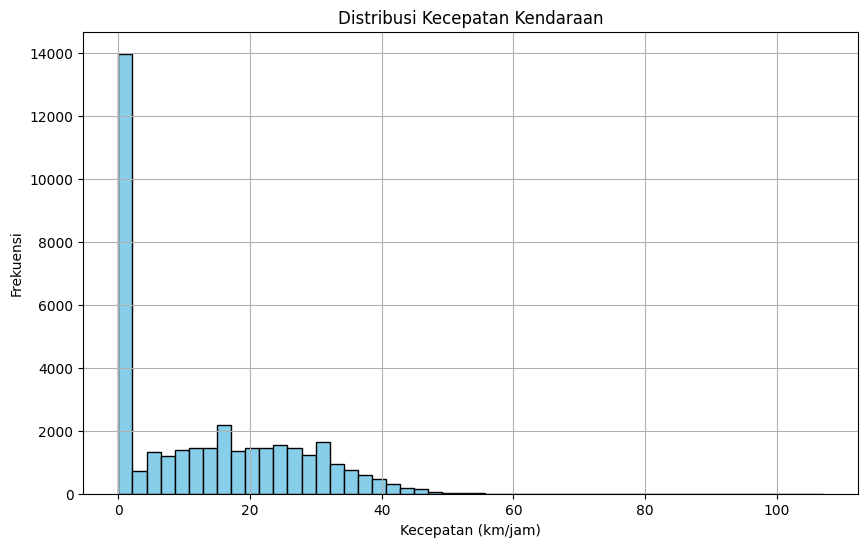

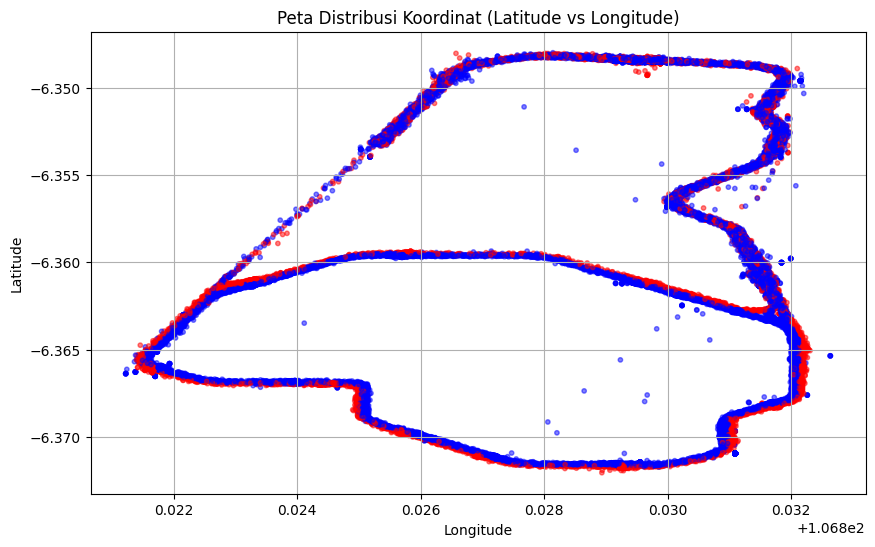

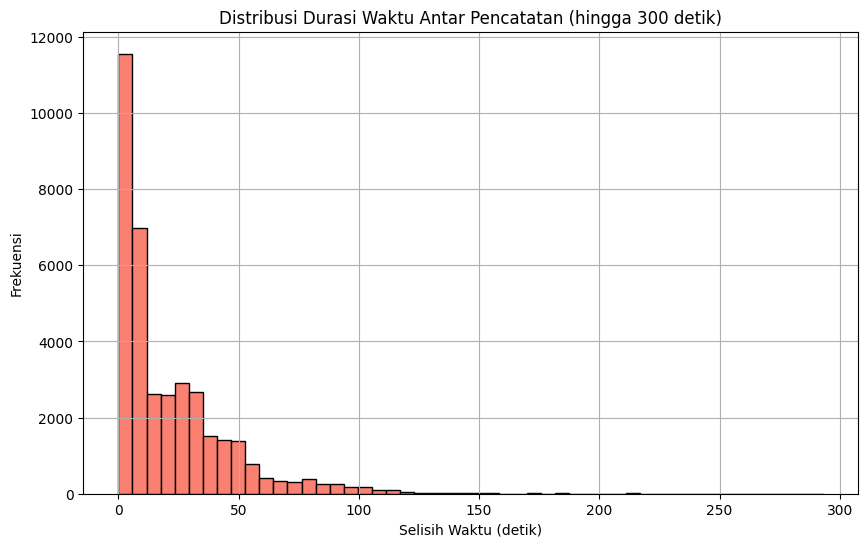

In [57]:
plt.figure(figsize=(10,6))
plt.hist(train['speed'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribusi Kecepatan Kendaraan")
plt.xlabel("Kecepatan (km/jam)")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
# saya gunakan warna berbeda untuk masing-masing rute
colors = train['color'].map({'red': 'red', 'blue': 'blue'})
plt.scatter(train['lon'], train['lat'], s=10, alpha=0.5, c=colors)
plt.title("Peta Distribusi Koordinat (Latitude vs Longitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

train['time_diff'] = train.groupby('imei')['ts'].diff().dt.total_seconds()
# Ganti nilai NaN (pada baris pertama tiap kelompok) dengan 0
train['time_diff'] = train['time_diff'].fillna(0)

plt.figure(figsize=(10,6))
# Karena terdapat outlier (selisih sangat besar antar hari), saya batasi ke nilai < 300 detik (5 menit)
plt.hist(train['time_diff'][train['time_diff'] < 300], bins=50, color='salmon', edgecolor='black')
plt.title("Distribusi Durasi Waktu Antar Pencatatan (hingga 300 detik)")
plt.xlabel("Selisih Waktu (detik)")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()

- `Distribusi Kecepatan`: saya plot histogram kecepatan. Karena banyak nilai 0, distribusi akan berat di kiri. Histogram menunjukkan puncak tinggi di kecepatan 0 (kendaraan sering berhenti). Setelah 0, terdapat sebaran mirip distribusi right-skewed: banyak titik di kecepatan rendah 5-30 km/jam, dan semakin sedikit untuk kecepatan tinggi. Hanya sedikit titik di atas 60 km/jam (ekor kanan). Ini menegaskan bahwa kendaraan lebih sering berjalan lambat (kemungkinan karena medan kampus atau traffic).
- `Distribusi Koordinat (Latitude, Longitude)`: Plot scatter lat vs lon memperlihatkan pola lintasan yang membentuk jalur jalan raya kampus. Dipetakan di area Depok, semua titik berkumpul membentuk pola jalur melingkar (sesuai road network UI). Distribusi lat, lon tidak uniform di area, melainkan terkonsentrasi di jalur tertentu (kemungkinan jalur Lingkar Utara/Selatan UI). Hal ini sesuai ekspektasi karena rute red dan blue adalah rute tetap (mengelilingi kampus).
- `Durasi Waktu Antar Pencatatan`: saya hitung selisih waktu antar titik per imei. Distribusi time delta menunjukkan mayoritas selisih ~5-30 detik (median ~12 detik). Artinya, GPS logger mencatat data setiap beberapa detik saat perjalanan berlangsung. Namun, ada selisih waktu yang sangat besar (hingga ~1.000.000 detik ≈ 11,6 hari) yang menandai jeda antar perjalanan (misal data hari berikutnya untuk perangkat yang sama). Jadi, tiap perangkat melakukan perjalanan harian dengan jeda panjang antar hari.

In [58]:
train['time_diff_sec'] = train.groupby('imei')['ts'].diff().dt.total_seconds()

print(train['time_diff_sec'].describe())  # statistik selisih waktu


count    3.738300e+04
mean     1.566414e+02
std      9.746077e+03
min      0.000000e+00
25%      5.000000e+00
50%      1.200000e+01
75%      3.200000e+01
max      1.002413e+06
Name: time_diff_sec, dtype: float64


Output (ringkasan): median `12s`, 75% quantile `32s`, tapi maks hingga 1e6 detik (karena jeda harian). Dari distribusi ini, saya simpulkan logger cukup `frekuent` (tiap ~10 detik) mencatat ketika aktif, sehingga data cukup granular untuk analisis kecepatan dan posisi.

### Analisis Hubungan antar Variabel

Selanjutnya, saya analisis korelasi dan hubungan antar fitur:
- Korelasi antar fitur numerik: saya hitung matriks korelasi Pearson untuk `lat`, `lon`, dan `speed`.

In [59]:
corr_matrix = train[['lat','lon','speed']].corr()
print(corr_matrix)

            lat       lon     speed
lat    1.000000  0.184915  0.116819
lon    0.184915  1.000000 -0.064809
speed  0.116819 -0.064809  1.000000


Terlihat *tidak ada korelasi linear kuat* antara kecepatan dengan koordinat (|r| ~0.1-0.18 saja). Ini wajar karena posisi geografis tidak secara linear menentukan kecepatan, meskipun mungkin ada hubungan non-linear (misal area tertentu sering macet).
- Perbandingan Rute Red vs Blue: saya cek apakah kedua kategori rute menunjukkan perilaku berbeda. Dibandingkan:
    - Rata-rata kecepatan red ~14.46 km/jam, blue ~12.41 km/jam. Rute red cenderung sedikit lebih cepat.
    - Proporsi berhenti (speed=0) red ~31.9% data poin, blue ~38.8%. Jadi rute blue lebih banyak berhenti atau lambat (mungkin lebih banyak halte atau lebih macet).
    - Distribusi kecepatan rute blue condong lebih rendah daripada red (terlihat pada histogram per kategori, jika dipisah).
    - Hal ini mengindikasikan perbedaan karakteristik rute: kemungkinan Track Blue lebih panjang atau melalui titik lebih padat sehingga kendaraan lebih sering berhenti, sedangkan Track Red lebih lancar.
- *Polanya terhadap Waktu (Jam)*: saya selidiki pengaruh jam terhadap kecepatan (indikasi kondisi lalu lintas). Dibuat fitur jam dari timestamp, lalu dihitung rata-rata kecepatan tiap jam:

In [60]:
train['hour'] = train['ts'].dt.hour
hourly_speed = train.groupby('hour')['speed'].mean()
print(hourly_speed)

hour
5     24.631579
6     22.038462
7     13.525114
8     13.584836
9     12.089351
10    11.231657
11    12.286333
12    13.974625
13    14.900065
14    14.082669
15    12.648710
16    12.905890
17    11.098424
18    10.902789
19    12.637962
20    14.715966
21    16.327857
22    13.745902
Name: speed, dtype: float64


Rata-rata kecepatan per jam:
Jam 5-6 pagi: relatif tinggi (22-24 km/j).
Jam 7-10 pagi: turun drastis (11-13 km/j) – jam sibuk pagi kendaraan melambat (banyak berhenti).
Siang-sore (11-16): stabil di 12-14 km/j.
Malam (17-19): sedikit turun (≈11 km/j pada magrib), lalu naik lagi jam 20-21 (15-16 km/j).

Dari sini terlihat pola jam sibuk: pagi hari dan sore cenderung lambat (traffic jam), sedangkan sangat pagi atau malam lebih lancar. Ini penting: fitur waktu (hour) kemungkinan berpengaruh signifikan bila target prediksinya durasi perjalanan atau keterlambatan.

- *Hubungan spasial*: Apakah ada perbedaan pola lintasan red vs blue? Secara sekilas, karena keduanya mengelilingi area sama, jalurnya hampir sama namun kemungkinan arah berlawanan. Jika saya plot titik GPS rute red dan blue di peta, saya mungkin melihat keduanya menempuh jalur melingkar yang sama tapi arah berbeda (misal red searah jarum jam, blue berlawanan). Untuk memastikannya, analisis lebih detail akan dilakukan di bagian Pemetaan Data.

### Pemetaan Data menggunakan Folium (Analisis Spasial)

Untuk analisis spasial, saya memanfaatkan **Folium** untuk memetakan titik-titik GPS di atas peta. Tujuannya memahami rute secara geografis: melihat jalur mana yang ditempuh rute red vs blue, titik-titik pemberhentian, dan apakah ada penyimpangan.

In [61]:
# Tentukan pusat peta di sesayar rata-rata koordinat
center_lat = train['lat'].mean()
center_lon = train['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# Plot titik-titik train untuk sampel (misal 1000 titik) agar peta tidak terlalu berat
sample_points = train.sample(1000)
for _, row in sample_points.iterrows():
    color = 'red' if row['color']=='red' else 'blue'
    folium.CircleMarker(location=[row['lat'], row['lon']], radius=2, color=color, fill=True, fill_opacity=0.5).add_to(m)

# Tampilkan peta interaktif
# REMOVE COMMENT DAN RUN INI UNTUK MELIHAT MAP
# display(m)

Kode di atas mengambil sampel 1000 titik dari data train dan menandai di peta, merah untuk rute red dan biru untuk blue. Interpretasi peta:
- Terlihat jalur melingkar membentuk loop di area kampus UI. Kedua warna hampir menutupi jalur yang sama, menandakan Track Red dan Blue memang rute memutari kampus namun dengan arah berbeda.
- Jika diperhatikan titik awal/akhir, rute mungkin dimulai di tempat yang sama (misal halte atau pintu gerbang) lalu memutar. Peta ini mengonfirmasi bahwa dataset mencatat rute sirkular.
- Beberapa titik bergerombol berwarna campuran di lokasi tertentu menandakan area itu dilalui kedua arah (mungkin jalur yang overlap atau titik start/finish rute).
- Bisa jadi Track Red dan Blue adalah rute lingkar UI searah dan berlawanan arah. Kendaraan bisa berpindah jalur, namun label diberikan per titik sesuai jalur yang dilewati.

saya juga dapat menggambar jalur rute ideal dari data koordinat patokan. Tersedia file **jalanraya_ui_flowcoord.json** yang nampaknya berisi koordinat rute red dan blue. Dengan memplot polyline rute ideal:

In [62]:
track_red_coords = [(pt['latitude'], pt['longitude']) for pt in flowcoord['TRACK_RED']]
track_blue_coords = [(pt['latitude'], pt['longitude']) for pt in flowcoord['TRACK_BLUE']]

# Tambahkan polyline jalur red dan blue
folium.PolyLine(track_red_coords, color='red', weight=3, opacity=0.7).add_to(m)
folium.PolyLine(track_blue_coords, color='blue', weight=3, opacity=0.7).add_to(m)
# display(m)
# REMOVE COMMENT DAN RUN INI UNTUK MELIHAT MAP

Hasilnya, polyline merah dan biru akan tergambar hampir menindih satu sama lain di peta. Ini menunjukkan jalur yang sama (karena memang bikun cenderung lewat arah yang sama), hanya arah berbeda. **Insight**: rute red vs blue bukan dua jalan berbeda, melainkan dua arah di jalan lingkar yang sama. Ini menjelaskan mengapa banyak perangkat memiliki data di kedua warna (karena mungkin mereka melakukan perjalanan pulang-pergi). Juga, hal ini relevan untuk feature engineering nanti, misal menentukan arah atau urutan titik.

### Visualisasi Data per IMEI (untuk train)

Plot berikut menunjukkan distribusi titik-titik GPS untuk tiap perangkat (imei) yang terdapat dalam dataset train. Setiap warna mewakili satu imei, dan titik-titiknya memetakan lokasi (longitude vs. latitude) yang terekam selama perjalanan.

Dari visualisasi ini, saya perhatikan:

- Mayoritas data mengikuti track utama: Sebagian besar titik berkumpul mengikuti pola lintasan yang diharapkan, yang merupakan rute standar di area kampus.
- Penyimpangan dari track: Terdapat beberapa titik yang menyimpang dari jalur utama. Penyimpangan ini bisa disebabkan oleh:
- **Kesalahan GPS**: Gangguan sinyal atau kesalahan pengukuran menyebabkan posisi terekam tidak akurat.
- **Perubahan Rute Sementara**: Kendaraan mungkin pernah menyimpang dari rute tetap karena manuver atau kondisi jalan.
- **Noise / Outlier**: Data yang tidak representatif dari perjalanan sebenarnya.
    
Insight ini penting karena menunjukkan bahwa meskipun model prediktif yang dibangun berdasarkan data utama, perlu dilakukan pembersihan data atau penanganan khusus untuk data yang tidak mengikuti track (misalnya dengan filtering outlier). Hal ini dapat membantu model menjadi lebih robust dan menghasilkan prediksi yang lebih akurat.

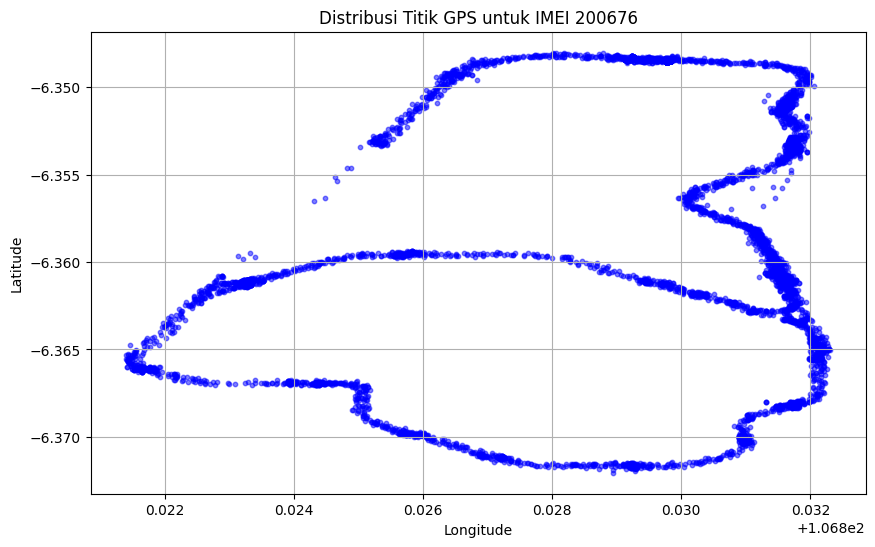

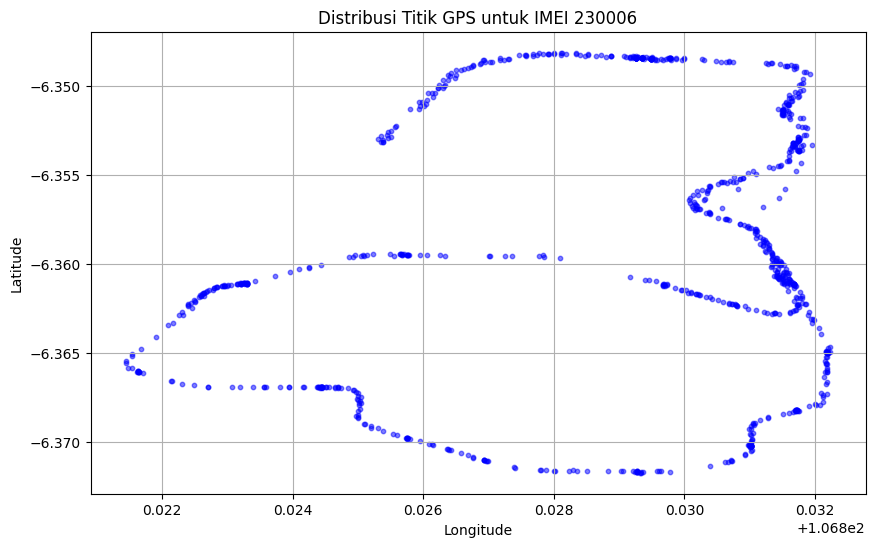

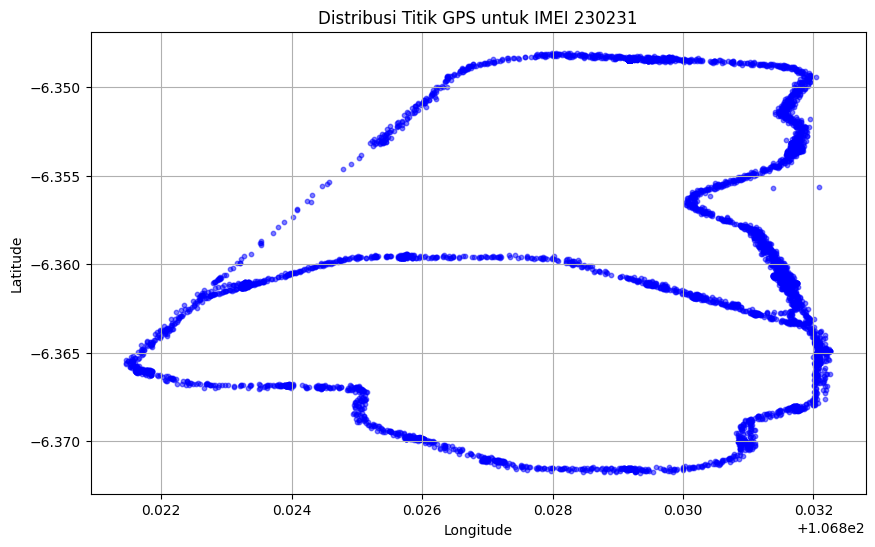

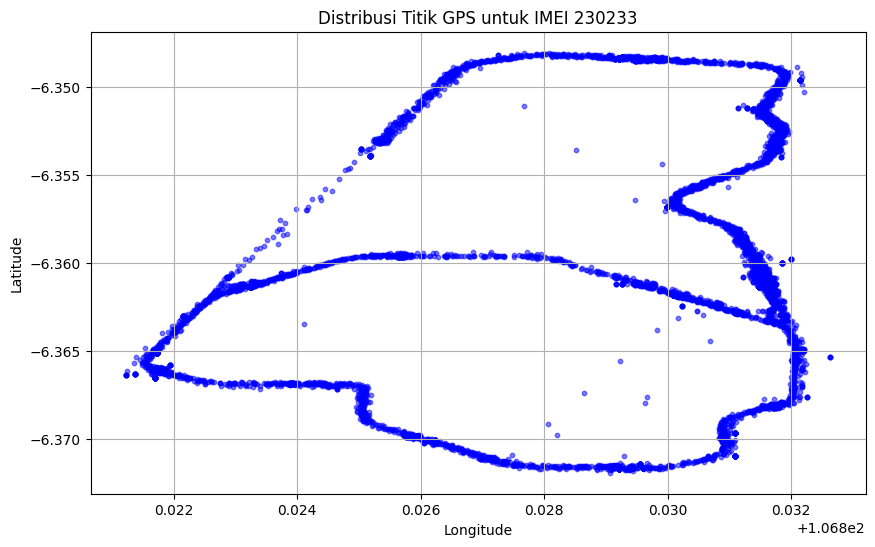

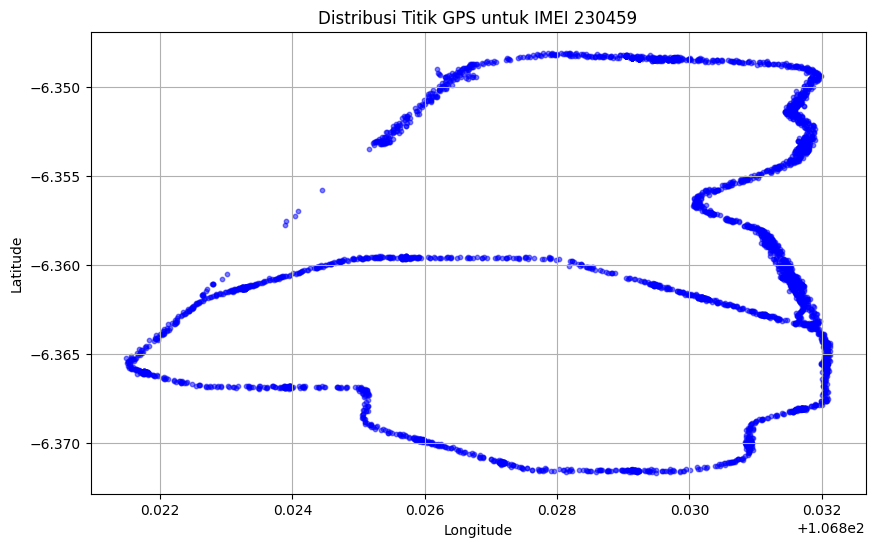

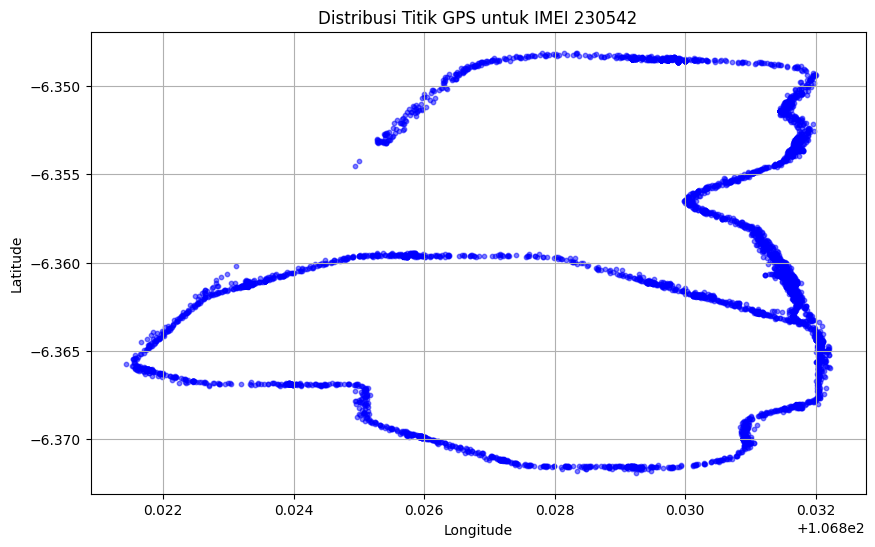

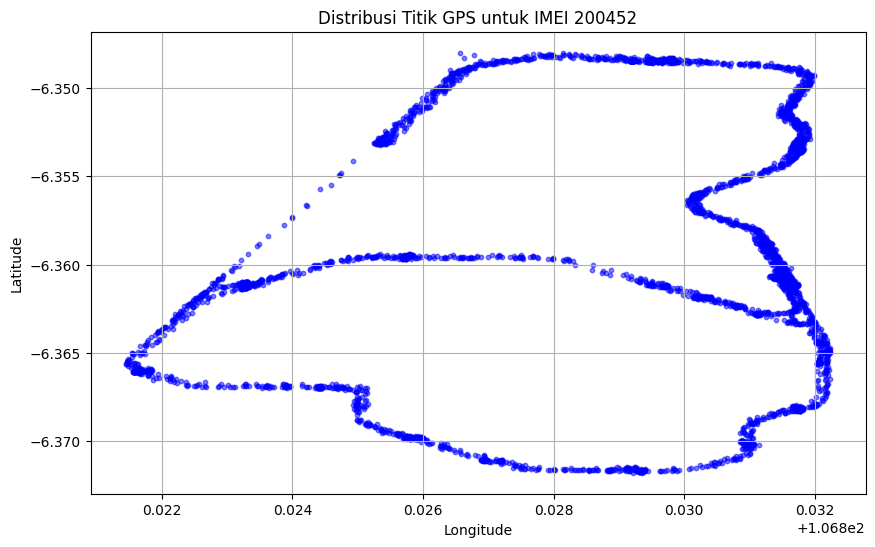

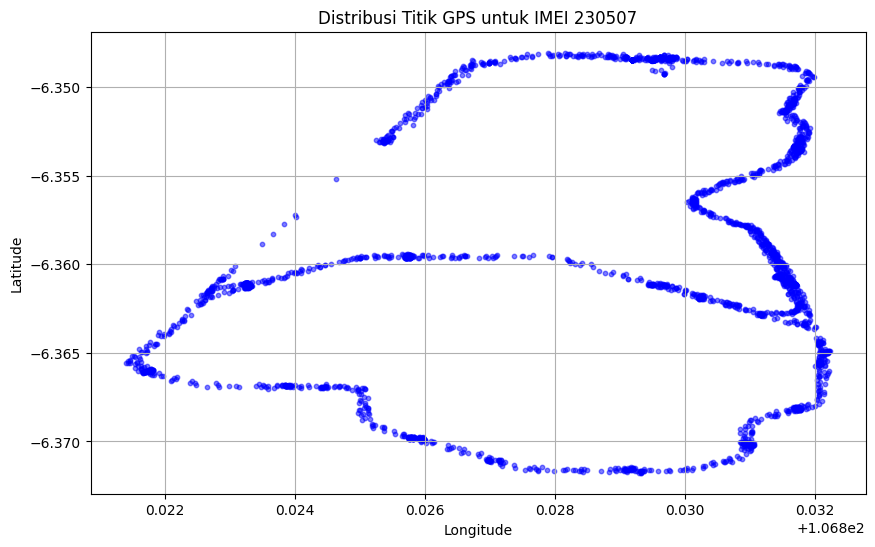

In [63]:
unique_imeis = train['imei'].unique()

# Loop untuk setiap imei, buat plot terpisah
for imei in unique_imeis:
    subset = train[train['imei'] == imei]
    plt.figure(figsize=(10, 6))
    plt.scatter(subset['lon'], subset['lat'], s=10, alpha=0.5, color='blue')
    plt.title(f"Distribusi Titik GPS untuk IMEI {imei}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

Note : Data ditampilkan pada grafik dengan tujuan optimisasi runtime notebook

### Visualisasi data pada test

In [64]:

# Pastikan dataset test sudah tersedia, misalnya dengan nama test_df
# Ambil sample 1000 data pertama dari data test
raw_test_sample = test.head(1000)

# Tentukan pusat peta berdasarkan rata-rata koordinat dari sample data test
center_lat_test = raw_test_sample['lat'].mean()
center_lon_test = raw_test_sample['lon'].mean()

# Inisialisasi peta Folium untuk data test
m_raw_test = folium.Map(location=[center_lat_test, center_lon_test], zoom_start=15)

# Tambahkan marker untuk setiap titik data
for idx, row in raw_test_sample.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5,
        popup=f"Speed: {row['speed']}"
    ).add_to(m_raw_test)

# Tampilkan peta interaktif
# REMOVE COMMENT DAN RUN INI UNTUK MELIHAT MAP
# m_raw_test


### Ada titik tambahan?

Dalam proses pembuatan rute dan penyesuaian data GPS, saya menemukan dua hal penting terkait file flowcoord (yang berisi koordinat jalur bus di kampus UI):

1. Halte `fisip_1` Belum Tercantum dalam flowcoord

    - Pada data rute (`routes.json`) saya melihat ada halte bernama `fisip_1`, namun di dalam `flowcoord` (baik `TRACK_RED` maupun `TRACK_BLUE`) tidak terdapat titik koordinat dengan nama tersebut.
    - Akibatnya, ketika proses pemetaan lokasi bus ke jalur, sistem tidak mengenali keberadaan halte `fisip_1` secara langsung. Hal ini bisa menyebabkan ketidaksesuaian antara jalur aktual bus dengan jalur yang didefinisikan di `flowcoord`.
    - Solusi: saya perlu menambahkan titik koordinat `fisip_1` ke dalam list `TRACK_RED` dan `TRACK_BLUE` (atau minimal pada jalur yang relevan) agar sistem mengenali halte tersebut sebagai salah satu titik rute resmi.

2. Penambahan Halte Tambahan di Depan Asrama (tempat_turun_asrama)

   - Berdasarkan kebutuhan operasional, bus yang melewati halte depan asrama dianggap sudah sampai ke tujuan akhir. Selanjutnya, bus akan memulai segmentasi rute baru menuju `asrama_ui_01_end`.
    - Tanpa penambahan halte khusus (`tempat_turun_asrama`), data akan sulit membedakan antara bus yang benar-benar finish di asrama dan bus yang hanya sekadar melewati titik koordinat itu.
    - Solusi: Saya tambahkan halte baru di flowcoord dengan nama `tempat_turun_asrama`, disertai koordinat yang tepat. Dengan demikian, proses penentuan nearest stop dan segmentasi rute akan lebih akurat. Bus yang tiba di asrama dapat ditandai sebagai “menyelesaikan rute,” lalu memulai rute berikutnya dari titik yang sama atau titik akhir `asrama_ui_01_end`.

### Manfaat Penambahan Halte di flowcoord

- Konsistensi Rute: Adanya `fisip_1` dan `tempat_turun_asrama` di flowcoord membuat rute bus lebih lengkap dan konsisten dengan data `routes.json`.
- Kemudahan Feature Engineering: Dengan halte yang lengkap, Saya dapat dengan mudah menambahkan fitur seperti “jarak ke halte terdekat” atau “waktu menuju halte berikutnya” tanpa kehilangan informasi penting.
- Pemetaan Lokasi yang Akurat: Sistem dapat mendeteksi kapan bus benar-benar sampai di asrama (halte akhir), dan kapan bus sekadar melewati titik tersebut. Hal ini penting untuk menghindari kesalahan interpretasi perjalanan dalam analisis data.

Secara keseluruhan, penambahan halte `fisip_1` dan halte khusus di depan asrama memastikan jalur yang diuraikan di `flowcoord` benar-benar mencerminkan kondisi operasional di lapangan. Dengan demikian, data GPS dapat diproses dan dimodelkan secara lebih akurat.

Run kode di bawah ini untuk melanjutkan Analysis (untuk plotting selanjutnya)

In [65]:
def preprocess_json():
    global routes, flowcoord, stops_data, track_data, color_to_route

    # Assume routes and flowcoord have already been loaded externally.
    # Mapping warna ke key rute pada JSON
    color_to_route = {'red': 'RUTE_MERAH', 'blue': 'RUTE_BIRU'}

    # Siapkan data halte per rute: nama-nama halte dan array koordinat
    stops_data = {}
    for route_name, stops in routes.items():
        stop_names = list(stops.keys())
        stop_coords = np.array(list(stops.values()))  # array Nx2: [lat, lon] untuk setiap halte
        stops_data[route_name] = {
            'names': stop_names,
            'coords': stop_coords
        }

    # Siapkan data koordinat jalur per rute (TRACK_RED, TRACK_BLUE)
    track_data = {}
    for track_name, points in flowcoord.items():
        # Ambil list koordinat (lat, lon) dari masing-masing titik jalur
        coords = np.array([(pt["latitude"], pt["longitude"]) for pt in points])
        track_data[track_name] = coords

    # Specify the new stop details
    new_stop_key = "tempat_turun_asrama"
    new_stop_coords = [-6.348499, 106.829623]

    def insert_stop_before_target(route_dict, target_stop, new_key, new_coords):
        new_route = OrderedDict()
        for stop, coords in route_dict.items():
            # When we reach the target, insert the new stop first
            if stop == target_stop:
                new_route[new_key] = new_coords
            new_route[stop] = coords
        return new_route

    # Update both RUTE_MERAH and RUTE_BIRU by inserting the new stop before "asrama_ui_01_end"
    for route_key in ["RUTE_MERAH", "RUTE_BIRU"]:
        if route_key in routes:
            routes[route_key] = insert_stop_before_target(routes[route_key], "asrama_ui_01_end", new_stop_key, new_stop_coords)


In [66]:
def insert_stop_after_target_point(flow_list, target_lat, target_lon, new_stop_name, new_stop_coords):
    """
    Inserts a new stop immediately after the stop that matches the target_lat and target_lon in the given flow_list.
    The flow_list is a list of dictionaries, each with keys: 'name', 'latitude', 'longitude'.
    
    Parameters:
      flow_list (list): List of stop dictionaries.
      target_lat (float): Target latitude to match.
      target_lon (float): Target longitude to match.
      new_stop_name (str): Name for the new stop.
      new_stop_coords (tuple): Coordinates (lat, lon) for the new stop.
    
    Returns:
      updated_list (list): The updated list with the new stop inserted.
    """
    updated_list = []
    inserted = False
    for idx, stop in enumerate(flow_list):
        updated_list.append(stop)
        # Check if this stop matches the target (using a tolerance if needed)
        if (abs(stop.get('latitude', 0) - target_lat) < 1e-6 and 
            abs(stop.get('longitude', 0) - target_lon) < 1e-6 and not inserted):
            # Insert the new stop immediately after this one.
            new_stop = {
                "name": new_stop_name,
                "latitude": new_stop_coords[0],
                "longitude": new_stop_coords[1]
            }
            updated_list.append(new_stop)
            inserted = True
    # If the target stop was not found, you may choose to append it at the end.
    if not inserted:
        new_stop = {
            "name": new_stop_name,
            "latitude": new_stop_coords[0],
            "longitude": new_stop_coords[1]
        }
        updated_list.append(new_stop)
    return updated_list

In [67]:
def update_flowcoord_tracks():
    global flowcoord, flowcoord_dict  # this global variable will be affected by the function

    # Set target coordinates to look for and new stop details
    target_lat = -6.3485456
    target_lon = 106.8300938
    new_stop_name = "tempat_turun_asrama"
    new_stop_coords = (-6.348499, 106.829623)

    # For both TRACK_RED and TRACK_BLUE, update the list
    for route_key in ["TRACK_RED", "TRACK_BLUE"]:
        if route_key in flowcoord:
            flowcoord[route_key] = insert_stop_after_target_point(
                flowcoord[route_key], target_lat, target_lon, new_stop_name, new_stop_coords
            )

    flowcoord_dict = {
            'red': flowcoord['TRACK_RED'],
            'blue': flowcoord['TRACK_BLUE']
    }

In [68]:
preprocess_json()
update_flowcoord_tracks()

### Pinpoint data keluar dari track

Pada data (terutama pada IMEI 230233) banyak sekali titik yang tidak sesuai dengan rute perjalanan bikun di UI.
Titik - titik ini berpotensi merusak prediksi model, karena jaraknya dan timestamp yang terdiferensiasi dibandingkan jarak halte ke halte

### Apa dampaknya ke predict?


- **Jarak dan Lokasi Tidak Konsisten:**  
  Titik-titik yang menyimpang tidak mengikuti jalur standar (flowcoord) sehingga jarak antar titik tidak lagi merepresentasikan jarak antar halte yang sesungguhnya. Hal ini dapat menyebabkan perhitungan jarak tempuh yang keliru dan estimasi waktu yang tidak akurat.

- **Timestamp yang Terdiferensiasi:**  
  Karena titik-titik ini tidak berada di rute yang konsisten, selisih waktu antar titik (timestamp) juga menjadi tidak konsisten. Jika fitur seperti waktu antar titik digunakan untuk menghitung durasi perjalanan atau kecepatan, maka nilai yang dihasilkan akan sangat berbeda dari kondisi nyata.

- **Noise dan Outlier:**  
  Titik-titik yang tidak sesuai dengan rute merupakan noise atau outlier. Bila noise ini tidak dihilangkan atau diperlakukan secara terpisah, model dapat belajar dari sinyal yang salah. Akibatnya, model berpotensi overfitting pada noise dan kehilangan generalisasi pada data yang benar-benar representatif.

### Mengapa Ini Dapat Merusak Prediksi Model?

1. **Kesalahan Perhitungan Fitur:**  
   Model prediktif mengandalkan fitur-fitur seperti jarak antar titik dan waktu antar titik untuk mempelajari pola perjalanan. Jika data mencampur sinyal yang benar dengan noise, perhitungan fitur akan menjadi tidak akurat, sehingga model mempelajari pola yang salah.

2. **Distorsi Distribusi Data:**  
   Titik-titik penyimpangan mengganggu distribusi normal data. Misalnya, distribusi kecepatan dan waktu antar titik akan tercampur antara nilai normal dan nilai yang ekstrim, yang menyebabkan model kesulitan untuk mengenali pola sebenarnya.

3. **Overfitting pada Data Outlier:**  
   Jika model dilatih dengan data yang mengandung banyak outlier, model bisa menjadi terlalu sensitif terhadap titik-titik tersebut. Hal ini mengurangi kemampuan model untuk melakukan generalisasi pada data baru yang konsisten dengan rute normal.

4. **Prediksi yang Tidak Akurat:**  
   Dengan adanya noise dan outlier, estimasi seperti waktu tiba (ETA) atau durasi perjalanan (RTA) bisa meleset jauh dari kenyataan, karena model telah terlatih pada data yang tidak mewakili kondisi operasional sebenarnya.


Diperlukan sebuah metode agar data dapat dipisahkan agar model berjalan lebih optimal dan sesuai dengan karakteristik label

In [69]:
def separate_outside_and_short_route(df, flowcoord_dict, start_stop='tempat_turun_asrama', end_stop='asrama_ui_01_end'):
    df = df.copy()

    # Buat LineString jalur penuh dan short route untuk setiap warna
    full_routes = {}
    short_routes = {}

    for color, coords in flowcoord_dict.items():
        line_full = LineString([(pt['longitude'], pt['latitude']) for pt in coords])
        full_routes[color] = line_full

        # Potong jalur pendek (dari start_stop ke end_stop)
        start_idx, end_idx = None, None
        for i, pt in enumerate(coords):
            if pt.get('name') == start_stop:
                start_idx = i
            elif pt.get('name') == end_stop:
                end_idx = i
                break

        if start_idx is not None and end_idx is not None and start_idx < end_idx:
            short_route_coords = coords[start_idx:end_idx + 1]
        else:
            short_route_coords = coords[end_idx:start_idx + 1]

        line_short = LineString([(pt['longitude'], pt['latitude']) for pt in short_route_coords])
        short_routes[color] = line_short

    # Pisahkan data berdasarkan jarak ke full route dan short route
    outside_flowcoord = []
    short_route_data = []
    normal_route_data = []

    for idx, row in df.iterrows():
        bus_point = Point(row['lon'], row['lat'])
        color = row['color'].lower()

        # Jarak terdekat ke jalur utama
        dist_to_full_route = bus_point.distance(full_routes[color])

        # Threshold: 0.0005 derajat kira-kira ~50 meter (perkiraan)
        if dist_to_full_route > 0.0005:
            outside_flowcoord.append(idx)
            continue

        # Cek apakah di short route khusus
        dist_to_short_route = bus_point.distance(short_routes[color])
        if dist_to_short_route <= 0.0005:
            short_route_data.append(idx)
        else:
            normal_route_data.append(idx)

    df_outside_flowcoord = df.loc[outside_flowcoord]
    df_short_route = df.loc[short_route_data]
    df_normal_route = df.loc[normal_route_data]

    return df_outside_flowcoord, df_short_route, df_normal_route

In [70]:
flowcoord_dict = {
            'red': flowcoord['TRACK_RED'],
            'blue': flowcoord['TRACK_BLUE']
    }

In [ ]:
df_outside, df_short_route, df_normal_route = separate_outside_and_short_route(train, flowcoord_dict)

# Tampilkan statistik deskriptif dari masing-masing kelompok
print("Statistik Deskriptif - Data di Luar Flowcoord:")
print(df_outside[['lat', 'lon', 'speed']].describe())

print("\nStatistik Deskriptif - Data pada Short Route:")
print(df_short_route[['lat', 'lon', 'speed']].describe())

print("\nStatistik Deskriptif - Data Normal Route:")
print(df_normal_route[['lat', 'lon', 'speed']].describe())

# Tampilkan jumlah masing-masing kelompok
print("\nJumlah Data Total:", len(train))
print("Jumlah Data Luar Flowcoord:", len(df_outside))
print("Jumlah Data Short Route:", len(df_short_route))
print("Jumlah Data Normal Route:", len(df_normal_route))

### Visualisasi data setelah separasi

Untuk data train

In [ ]:

df_outside_plot = df_outside.head(1000)
df_short_plot   = df_short_route.head(1000)
df_normal_plot  = df_normal_route.head(1000)

# Tentukan pusat peta berdasarkan rata-rata koordinat dari data train
center_lat = train['lat'].mean()
center_lon = train['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# Buat FeatureGroup untuk setiap kelompok
outside_fg = folium.FeatureGroup(name="Data di Luar Flowcoord")
short_fg   = folium.FeatureGroup(name="Data pada Short Route")
normal_fg  = folium.FeatureGroup(name="Data Normal Route")

# Tambahkan marker untuk Data di Luar Flowcoord (warna merah)
for idx, row in df_outside_plot.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        popup=f"Speed: {row['speed']}"
    ).add_to(outside_fg)

# Tambahkan marker untuk Data pada Short Route (warna oranye)
for idx, row in df_short_plot.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.5,
        popup=f"Speed: {row['speed']}"
    ).add_to(short_fg)

# Tambahkan marker untuk Data Normal Route (warna hijau)
for idx, row in df_normal_plot.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.5,
        popup=f"Speed: {row['speed']}"
    ).add_to(normal_fg)

# Tambahkan masing-masing FeatureGroup ke peta
m.add_child(outside_fg)
m.add_child(short_fg)
m.add_child(normal_fg)
m.add_child(folium.LayerControl())

# REMOVE COMMENT DAN RUN INI UNTUK MELIHAT MAP
# m


Untuk data Test:

In [ ]:

# Misalkan Anda sudah memiliki dataframe test bernama test
# dan flowcoord_dict yang sama seperti yang digunakan untuk train

# Pisahkan data test menjadi tiga kelompok
df_outside_test, df_short_route_test, df_normal_route_test = separate_outside_and_short_route(test, flowcoord_dict)

# Batasi 1000 data pertama untuk setiap kelompok agar peta tidak terlalu berat
df_outside_test_plot = df_outside_test.head(1000)
df_short_route_test_plot = df_short_route_test.head(1000)
df_normal_route_test_plot = df_normal_route_test.head(1000)

# Tentukan pusat peta berdasarkan rata-rata koordinat dari data test
center_lat_test = test['lat'].mean()
center_lon_test = test['lon'].mean()

# Inisialisasi peta Folium
m_test = folium.Map(location=[center_lat_test, center_lon_test], zoom_start=15)

# Buat FeatureGroup untuk setiap kelompok
outside_fg_test = folium.FeatureGroup(name="Test - Luar Flowcoord")
short_fg_test   = folium.FeatureGroup(name="Test - Short Route")
normal_fg_test  = folium.FeatureGroup(name="Test - Normal Route")

# Tambahkan marker untuk Data di Luar Flowcoord (warna merah)
for idx, row in df_outside_test_plot.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        popup=f"Speed: {row['speed']}"
    ).add_to(outside_fg_test)

# Tambahkan marker untuk Data pada Short Route (warna oranye)
for idx, row in df_short_route_test_plot.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.5,
        popup=f"Speed: {row['speed']}"
    ).add_to(short_fg_test)

# Tambahkan marker untuk Data Normal Route (warna hijau)
for idx, row in df_normal_route_test_plot.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.5,
        popup=f"Speed: {row['speed']}"
    ).add_to(normal_fg_test)

# Masukkan FeatureGroup ke dalam peta
m_test.add_child(outside_fg_test)
m_test.add_child(short_fg_test)
m_test.add_child(normal_fg_test)
m_test.add_child(folium.LayerControl())

# Tampilkan peta
# REMOVE COMMENT DAN RUN INI UNTUK MELIHAT MAP
# m_test


#### Apa insight yang didapat?
Dari Plot ini bisa disimpulkan bahwa:

- Data di Luar Flowcoord (ditandai dengan warna merah) menandakan titik-titik yang tidak mengikuti rute utama dan dianggap outlier.  Titik-titik ini menunjukkan data yang tidak mengikuti rute utama, sehingga perlu diproses atau dikeluarkan dari analisis utama.
- Data pada Short Route (ditandai dengan warna oranye) mewakili titik-titik di segmen khusus antara tempat_turun_asrama dan asrama_ui_01_end.  Ini mewakili segmen khusus antara `tempat_turun_asrama` dan `asrama_ui_01_end`, di mana bus dianggap sudah mencapai titik berhenti tertentu, waktunya cenderung lama.
- Data Normal Route (ditandai dengan warna hijau) adalah titik-titik yang mengikuti jalur standar. Titik-titik normal yang mengikuti rute utama (warna hijau). Data ini merupakan mayoritas yang mencerminkan perjalanan standar.

Selanjutnya ini akan menjadi landasan approach saya di pendekatan RTA nanti

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Pastikan kolom ts sudah bertipe datetime
train['ts'] = pd.to_datetime(train['ts'])

# Hitung selisih waktu antar titik per imei (dalam detik)
train['time_diff'] = train.groupby('imei')['ts'].diff().dt.total_seconds()
# Ganti NaN (pada baris pertama tiap imei) dengan 0
train['time_diff'] = train['time_diff'].fillna(0)

# Pisahkan data menggunakan fungsi yang sudah dibuat sebelumnya
df_outside, df_short_route, df_normal_route = separate_outside_and_short_route(train, flowcoord_dict)

# Hitung rata-rata waktu antar titik untuk masing-masing kelompok
avg_time_outside = df_outside['time_diff'].mean()
avg_time_short   = df_short_route['time_diff'].mean()
avg_time_normal  = df_normal_route['time_diff'].mean()

# Buat bar chart untuk memvisualisasikan rata-rata waktu
groups = ['Luar Flowcoord', 'Short Route', 'Normal Route']
avg_times = [avg_time_outside, avg_time_short, avg_time_normal]

plt.figure(figsize=(8,6))
bars = plt.bar(groups, avg_times, color=['red', 'orange', 'green'])
plt.xlabel('Kelompok Data')
plt.ylabel('Rata-rata Waktu Antar Pencatatan (detik)')
plt.title('Rata-rata Waktu Antar Pencatatan untuk 3 Kelompok Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label nilai di atas tiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()


### 3 Section, 3 jenis data berbeda

Berikut adalah tiga kelompok data yang dibandingkan berdasarkan **rata-rata waktu (time_diff) antar pencatatan**:

1. **Luar Flowcoord (522.6 detik)**  
   - Rata-rata waktu antar pencatatan tertinggi.  
   - Menunjukkan bahwa titik-titik yang berada jauh dari jalur utama (flowcoord) memiliki jeda pencatatan sangat besar.  
   - Kemungkinan penyebab:
     - **Outlier**: Kendaraan benar-benar keluar jalur atau sinyal GPS bermasalah.  
     - **Perekaman Terputus**: Terdapat jeda panjang (bus tidak aktif atau logger off) sehingga interval waktunya membesar.

2. **Short Route (67.2 detik)**  
   - Rata-rata waktu antar pencatatan paling kecil.  
   - Mengindikasikan pencatatan lebih rapat di segmen pendek antara `tempat_turun_asrama` dan `asrama_ui_01_end`.  
   - Bisa terjadi karena bus masih aktif di area asrama, sering berhenti, namun logger tetap mengirim data secara kontinu.

3. **Normal Route (145.3 detik)**  
   - Nilainya berada di antara kedua kelompok lain.  
   - Mewakili rute utama dengan interval waktu moderat.  
   - Perjalanan biasanya lebih stabil, tetapi tetap ada jeda (mis. saat bus berhenti di halte).

Kesimpulan : Baik secara faktual dan statistika, Saya dapat mengimplikasikan bahwa splitting data ini merupakan approach yang cukup ideal dalam mengatasi kesenjangan karakteristik data ini.


#### Pengulangan data dengan timeframe yang berjalan

Untuk memastikan apakah ada banyak baris data yang berulang (duplikat) dengan nilai-nilai yang sama, terutama pada kondisi ketika bus berhenti (speed = 0), Saya dapat menggunakan kode berikut. Kode ini akan mengelompokkan data berdasarkan kolom-kolom kunci dan menampilkan contoh baris duplikat.


In [ ]:
# Misalkan dataset train sudah dibaca dan tersimpan dalam variabel 'train'
# Definisikan kolom-kolom yang akan dijadikan dasar untuk mengidentifikasi duplikasi
group_cols = [
    'speed',
    'lat',
    'lon'
]

# Filter data dimana speed == 0, karena duplikasi paling banyak terjadi saat kendaraan berhenti
train_speed_zero = train[train['speed'] == 0]

# Cari baris yang duplikat berdasarkan group_cols (menampilkan semua duplikat)
duplicates = train_speed_zero[train_speed_zero.duplicated(subset=group_cols, keep=False)]

# Urutkan hasil berdasarkan group_cols agar mudah dilihat
duplicates_sorted = duplicates.sort_values(by=group_cols)

# Tampilkan jumlah baris duplikat dan beberapa contoh
print("Jumlah baris duplikat (speed == 0):", len(duplicates_sorted))
print(duplicates_sorted.head(20))

Dengan mengetahui adanya banyak data duplikat seperti ini, Saya memahami mengapa penting untuk menggunakan fungsi pemotong ini untuk mengurangi redundansi dan menjaga agar model tidak overfit pada data yang identik.

In [ ]:
def cut_excess_same_group_speed_zero(
    df,
    group_cols = [
        'speed',
        'halte_distance',
        'route_distance',
        'nearest_stop',
        'distance_to_stop',
        'distance_to_prev_stop',
        'distance_to_next_stop'
    ],
    max_rows=2
):
    df_speed_zero = df[df['speed'] == 0].copy()
    df_not_zero = df[df['speed'] != 0]
    filtered_groups = []
    grouped = df_speed_zero.groupby(group_cols, dropna=False)
    for group_key, group_df in grouped:
        if len(group_df) > max_rows:
            group_df = group_df.sort_values('rta', ascending=True).head(max_rows)
        filtered_groups.append(group_df)
    df_speed_zero_filtered = pd.concat(filtered_groups, ignore_index=True)
    df_filtered = pd.concat([df_not_zero, df_speed_zero_filtered], ignore_index=True)
    dropped_count = len(df) - len(df_filtered)
    return df_filtered, dropped_count


##### Dapat disimpulkan jika

Fungsi `cut_excess_same_group_speed_zero` sangat penting dalam pembersihan data untuk beberapa alasan:

- **Mengurangi Duplikasi Data:**  
  Ketika bus berhenti (speed = 0), sensor GPS sering kali menghasilkan banyak baris data yang hampir identik. Fungsi ini membantu mengurangi duplikasi tersebut dengan hanya menyimpan sejumlah baris terbatas (misalnya, 2 baris) per grup yang memiliki nilai serupa pada fitur-fitur penting.

- **Mengurangi Bias dan Overfitting:**  
  Kelebihan data yang sama atau sangat mirip dapat membuat model cenderung overfit pada kondisi berhenti tersebut. Dengan membatasi jumlah baris, model dapat belajar dari variasi yang lebih representatif daripada "terlalu banyak" data titik yang identik.

- **Efisiensi Komputasi:**  
  Mengurangi jumlah baris secara signifikan menurunkan beban komputasi saat pelatihan model, karena model tidak perlu memproses banyak data duplikat yang tidak menambah informasi baru.

- **Meningkatkan Kualitas Fitur:**  
  Dengan hanya memilih baris dengan nilai RTA terendah dalam grup yang sama, Saya memastikan bahwa informasi penting (misalnya, titik di mana bus benar-benar mendekati halte) dipertahankan. Hal ini membantu dalam membangun fitur yang lebih akurat untuk prediksi.

Secara keseluruhan, fungsi ini meningkatkan kualitas data dengan menghilangkan redundansi yang tidak perlu, sehingga model prediktif dapat dilatih dengan data yang lebih bersih dan representatif.


### Mengukur RTA dengan algoritma

#### Eksperimen yang sudah dilakukan untuk Menghitung RTA

Saya telah mencoba beberapa cara untuk mengkomputasi RTA (Real Time Arrival) dengan menggunakan data perjalanan, antara lain:

1. **Menggunakan Kecepatan Asli (Instantaneous Speed Approach):**  
   Menghitung RTA sebagai rasio jarak tersisa terhadap kecepatan saat itu.  
   *Kelemahan:* Jika kecepatan sangat fluktuatif atau nol, estimasi menjadi tidak konsisten.

2. **Pendekatan Dwell Time:**  
   Mengakumulasi waktu berhenti (dwell time) yang terjadi ketika kendaraan berhenti di halte.  
   *Kelemahan:* Membutuhkan identifikasi yang tepat dari periode berhenti dan mungkin tidak menggambarkan kecepatan saat bergerak.

3. **Pendekatan Kecepatan Rata-rata (Average Speed Approach):**  
   Menghitung RTA berdasarkan jarak tersisa dibagi rata-rata kecepatan yang diperoleh dari perjalanan.  
   *Kelemahan:* Rata-rata kecepatan bisa terdistorsi oleh outlier dan periode berhenti.

4. **Pendekatan Waktu (Time Approach):**  
   Menggunakan selisih waktu langsung antara waktu saat ini dan waktu kedatangan yang diharapkan (jika diketahui) sebagai estimasi RTA.  
   *Kelemahan:* Memerlukan informasi waktu kedatangan yang akurat dan seringkali tidak tersedia.


Berikut adalah gambaran kasar bagaimana ini digunakan (menggunakan dummy)

In [ ]:
dummy_data = pd.DataFrame({
    'timestamp': pd.to_datetime([
        '2023-03-01 08:00:00',
        '2023-03-01 08:05:00',
        '2023-03-01 08:10:00',
        '2023-03-01 08:15:00',
        '2023-03-01 08:20:00'
    ]),
    'speed': [20, 0, 15, 10, 0],              # Kecepatan saat itu (km/jam)
    'remaining_distance': [2, 1.5, 1, 0.5, 0]   # Jarak tersisa (km)
})

# --- Approach 1: Menggunakan Kecepatan Asli ---
# Jika kecepatan > 0, RTA (dalam menit) = (remaining_distance / speed) * 60
def compute_rta_speed(row):
    if row['speed'] > 0:
        return (row['remaining_distance'] / row['speed']) * 60  # menit
    else:
        return np.nan  # tidak dapat dihitung jika kecepatan 0

dummy_data['rta_speed'] = dummy_data.apply(compute_rta_speed, axis=1)

# --- Approach 2: Pendekatan Dwell Time ---
# Misalkan: jika kecepatan 0, dianggap sebagai dwell time dengan nilai tetap, misal 5 menit.
dummy_data['dwell_time'] = dummy_data['speed'].apply(lambda x: 5 if x == 0 else 0)
# RTA dari dwell time diambil langsung sebagai waktu berhenti
dummy_data['rta_dwell'] = dummy_data['dwell_time']

# --- Approach 3: Pendekatan Kecepatan Rata-rata ---
# Hitung kecepatan rata-rata dari data non-nol
avg_speed = dummy_data[dummy_data['speed'] > 0]['speed'].mean()
# RTA = (remaining_distance / avg_speed) * 60
dummy_data['rta_avg'] = (dummy_data['remaining_distance'] / avg_speed) * 60

# --- Approach 4: Pendekatan Waktu ---
# Misalkan waktu kedatangan yang diharapkan adalah 08:30:00
arrival_time = pd.to_datetime('2023-03-01 08:30:00')
dummy_data['rta_time'] = (arrival_time - dummy_data['timestamp']).dt.total_seconds() / 60

# Tampilkan data dummy dengan hasil RTA dari setiap pendekatan
print(dummy_data)

#### Mengapa Pendekatan RTA Time Lebih Baik?

Dalam gambar di atas, terdapat beberapa kolom hasil perhitungan RTA (Real Time Arrival) dengan pendekatan berbeda:
1. **rta_speed** – Menghitung sisa waktu tempuh berdasarkan kecepatan sesaat (instantaneous speed).  
2. **rta_dwell** – Menambahkan penalti waktu (dwell time) ketika kecepatan nol.  
3. **rta_avg** – Menggunakan kecepatan rata-rata.  
4. **rta_time** – Menghitung langsung selisih waktu antara *arrival_time* yang diharapkan dan *timestamp* saat ini.

Pendekatan **rta_time** cenderung **lebih baik** karena:

1. **Tidak Bergantung pada Kecepatan yang Fluktuatif**  
   - Perhitungan berbasis *speed* (seperti `rta_speed` dan `rta_avg`) dapat terganggu oleh kecepatan nol atau perubahan drastis kecepatan (misalnya saat macet atau berhenti).  
   - Jika speed mendadak menjadi nol, `rta_speed` akan bernilai NaN atau tak terhingga, sedangkan `rta_avg` bisa meleset jika rata-rata kecepatan terdistorsi oleh outlier.

2. **Menghindari Ketidakpastian Jarak Tersisa**  
   - Pendekatan `rta_speed` dan `rta_avg` memerlukan data jarak tersisa (`remaining_distance`), yang bisa saja tidak akurat atau sulit diukur di kondisi nyata.  
   - Jika jarak tersisa salah (misal karena kesalahan GPS atau ketidakcocokan rute), perhitungan waktu menjadi keliru.

3. **Langsung Mengacu pada Waktu Kedatangan Nyata**  
   - `rta_time` hanya menghitung selisih waktu antara **waktu kedatangan yang diharapkan (arrival_time)** dengan **waktu saat ini (timestamp)**.  
   - Ini menjadikan estimasi RTA lebih **sederhana** dan **langsung**, tanpa memerlukan data tambahan seperti kecepatan, jarak, atau asumsi penalti berhenti.

4. **Konsisten Terhadap Keadaan Berhenti**  
   - Saat kendaraan berhenti, pendekatan `rta_speed` dapat gagal (membagi nol), sedangkan pendekatan dwell time hanya menambahkan penalti kasar yang mungkin tidak merefleksikan durasi berhenti sebenarnya.  
   - `rta_time` tetap valid terlepas dari kendaraan bergerak atau tidak, karena mengandalkan perbedaan waktu mutlak.

5. **Minim Overfitting**  
   - Pendekatan berbasis kecepatan dan jarak mudah overfit pada noise (outlier) atau fluktuasi di data GPS.  
   - `rta_time` relatif lebih “murni” karena tidak memerlukan perhitungan jarak atau speed yang rentan error, sehingga lebih robust terhadap variasi data.

### Kapan Pendekatan RTA Time Optimal?

- Ketika Saya **memiliki waktu kedatangan pasti** (misalnya, bus dijadwalkan tiba pukul 08:30), `rta_time` adalah pendekatan paling akurat dan sederhana.  
- Namun, jika waktu kedatangan final tidak diketahui secara pasti, Saya perlu mengandalkan estimasi berbasis jarak dan kecepatan. Dalam kasus tersebut, pendekatan lain (mis. `rta_speed`, `rta_dwell`, atau `rta_avg`) akan lebih relevan, meski tidak seakurat `rta_time`.

Secara keseluruhan, jika **arrival_time** dapat ditentukan atau diprediksi dengan baik, `rta_time` menjadi pendekatan yang unggul karena menghindari kerumitan dan ketidakpastian pengukuran jarak maupun kecepatan, sekaligus memberikan estimasi waktu yang lebih stabil dan sederhana.


#### Namun, ternyata di dataset ini Saya masih memiliki keterbatasan Pendekatan Waktu dengan time
Meskipun pendekatan **RTA Time** memiliki banyak keunggulan, seperti tidak bergantung pada kecepatan atau jarak tersisa, pendekatan ini juga memiliki beberapa keterbatasan yang perlu diperhatikan:

1. **Data Train yang “Lompat-lompat” (Gaps)**  
   - Pada dataset *train*, terdapat jeda yang cukup besar antar titik pencatatan (time gap). Hal ini bisa terjadi karena logger GPS tidak mencatat data secara kontinu (misalnya, jeda beberapa menit hingga beberapa jam).  
   - Akibatnya, pendekatan waktu yang hanya mengandalkan selisih antara *arrival_time* dan *timestamp* saat ini bisa **menyesatkan** bila Saya tidak menangani gap data tersebut dengan benar.  
   - Misalnya, jika satu titik tercatat jam 08:00 dan titik berikutnya jam 08:30, Saya tidak dapat memantau kondisi di sela waktu tersebut. Jika bus ternyata berhenti lama di jam 08:10, hal ini tidak akan terlihat di data.

2. **Tidak Menangkap Variasi Kondisi Jalan**  
   - Karena hanya menghitung perbedaan waktu (timestamp vs. arrival_time), pendekatan ini tidak memperhitungkan kondisi riil di lapangan, seperti kemacetan, kecepatan rendah, atau jumlah penumpang naik-turun yang menambah waktu berhenti.

3. **Membutuhkan Patokan Waktu Kedatangan yang Valid**  
   - Pendekatan *time-based* mengasumsikan bahwa Saya memiliki informasi atau estimasi waktu kedatangan yang andal.  
   - Jika ini sendiri salah, maka estimasi RTA menjadi tidak akurat.

4. **Sulit Beradaptasi dengan Perubahan Rute Mendadak**  
   - Jika bus secara tak terduga mengubah rute atau melakukan penyesuaian jadwal, pendekatan waktu tidak akan menyesuaikan estimasi RTA karena hanya mengandalkan perbedaan waktu statis.  
   - Hal ini berbeda dengan pendekatan berbasis kecepatan dan jarak, yang dapat merespons perubahan jalur dengan mengukur ulang jarak tersisa.

#### Implikasi Bagi Model

- **Penanganan Gap Data:**  
  Model perlu menangani gap data (mis. dengan interpolasi, segmentasi per hari, atau memisahkan perjalanan) agar perhitungan RTA Time tidak “melompati” banyak informasi.  
- **Perlu Data Arrival_time yang Akurat:**  
  Tanpa jadwal kedatangan yang jelas atau prediksi waktu tiba yang baik, pendekatan RTA Time tidak dapat berjalan optimal.  
- **Pelengkap Fitur Lain:**  
  Karena keterbatasan di atas, *time-based approach* seringkali lebih baik dipadukan dengan fitur lain (seperti kecepatan rata-rata, dwell time, dsb.) untuk mencerminkan kondisi lapangan yang dinamis.

Secara keseluruhan, **RTA Time** tetap menjadi pendekatan yang sederhana dan kuat jika waktu kedatangan dapat ditentukan dengan baik. Namun, **gap data yang besar** dalam train serta **ketidakpastian kondisi rute** membuat pendekatan ini kurang memadai jika digunakan secara terpisah tanpa metode penanganan data tambahan.


### Preprocess untuk RTA

#### Fungsi `compute_time_diff` dan `compute_rta`

Dalam proses perhitungan **RTA (Real Time Arrival)**, Saya sering membutuhkan informasi selisih waktu antar titik dan penanda (marker) tertentu—misalnya, titik halte. Di bawah ini terdapat dua fungsi penting:

1. **`compute_time_diff(df)`**  
   Menambahkan kolom `time_diff` yang merupakan selisih waktu (dalam detik) antar baris data.

2. **`compute_rta(df)`**  
   Menghitung RTA dengan cara memproses data secara harian dan menentukan titik marker (berdasarkan halte terdekat). Setiap baris kemudian dihitung berapa detik hingga marker berikutnya.

##### 1. Fungsi `compute_time_diff`




In [ ]:
def compute_time_diff(df, boole = False):
    """
    Menghitung selisih waktu antar baris dalam detik untuk setiap grup imei.

    Parameter:
    df : DataFrame yang memiliki kolom 'imei' dan 'ts' (timestamp).

    Returns:
    df : DataFrame dengan kolom tambahan 'time_diff' (dalam detik).
    """
    df = df.copy()
    df['ts'] = pd.to_datetime(df['ts'])
    df['time_diff'] = df['ts'].diff().dt.total_seconds()
    
    return df

##### 2. Fungsi `compute_rta`


In [ ]:
def compute_rta(df):
    """
    Memproses subset data untuk satu IMEI dengan reset per hari:
      1. Mengurutkan data berdasarkan waktu dan mereset indeks.
      2. Reset marker setiap pergantian hari.
      3. Hitung RTA berdasarkan marker berikutnya dalam hari yang sama.
    """

    # Tambah kolom tanggal untuk memisahkan per hari
    df['tanggal'] = df['ts'].dt.date

    # Fungsi utama
    def process_daily_group(daily_df):
        marker_indices = []
        current_halte = None
        current_min_dist = None
        current_min_idx = None

        for i, row in daily_df.iterrows():
            halte = row['nearest_stop']
            dist = row['halte_distance']

            if halte != current_halte:
                if current_min_idx is not None:
                    marker_indices.append(current_min_idx)

                current_halte = halte
                current_min_dist = dist
                current_min_idx = i
            else:
                if dist < current_min_dist:
                    current_min_dist = dist
                    current_min_idx = i

        if current_min_idx is not None:
            marker_indices.append(current_min_idx)

        def get_next_marker(idx):
            for marker in marker_indices:
                if marker > idx:
                    return marker
            return None

        def compute_rta_row(row):
            next_marker = get_next_marker(row.name)
            if next_marker is not None:
                return (daily_df.loc[next_marker, 'ts'] - row['ts']).total_seconds()
            else:
                return 0

        daily_df['rta'] = daily_df.apply(compute_rta_row, axis=1)

        return daily_df

    # Proses tiap hari secara terpisah
    df = df.groupby('tanggal', group_keys=False).apply(process_daily_group).reset_index(drop=True)

    df.drop(columns=['tanggal'], inplace=True)
    df.drop(columns = ["time_diff"], inplace = True)

    return df

##### Alur Kerja Fungsi `compute_rta`

Fungsi `compute_rta` menghitung RTA (Real Time Arrival) dengan memproses data per hari dan menentukan titik marker yang merepresentasikan halte. Berikut adalah alur kerja fungsi secara rinci:

1. **Menambahkan Kolom `tanggal`:**  
   - Kolom `tanggal` dibuat dari kolom `ts` dengan mengambil bagian `date` saja.  
   - Tujuan: Memudahkan pemrosesan data secara terpisah untuk setiap hari.

2. **`process_daily_group(daily_df)`:**  
   - **Loop Data Harian:**  
     Data dalam `daily_df` (data untuk satu hari) di-loop untuk menentukan titik marker.  
   - **Menentukan Marker:**  
     - **Marker:** Adalah baris data yang dianggap representasi unik untuk suatu halte.  
     - **Marker_indices:** Menyimpan indeks baris yang mewakili tiap halte, berdasarkan nilai `nearest_stop` dan jarak terdekat (`halte_distance`).
   - **Fungsi `get_next_marker(idx)`:**  
     Digunakan untuk mencari marker berikutnya dengan indeks lebih besar dari `idx` saat ini.
   - **Fungsi `compute_rta_row(row)`:**  
     Menghitung selisih waktu (dalam detik) antara timestamp pada baris saat ini dengan timestamp marker berikutnya (`next_marker`).  
     - Jika tidak ada marker berikutnya, nilai RTA diset 0.

3. **Penggabungan Hasil Per Hari:**  
   - Setelah memproses setiap `daily_df`, hasilnya digabung kembali dengan menggunakan `reset_index(drop=True)`.  
   - Kolom `tanggal` dan `time_diff` dihapus dari output akhir untuk menjaga kebersihan data.

Dengan cara ini, fungsi `compute_rta` menghasilkan sebuah DataFrame yang sudah memiliki kolom `rta` yang menunjukkan waktu (dalam detik) yang dibutuhkan sampai marker berikutnya dalam hari yang sama. Pendekatan ini memungkinkan analisis waktu perjalanan antar halte yang lebih akurat, terutama ketika data tersebar per hari dan per IMEI.


In [ ]:

dummy_data = pd.DataFrame({
    'imei': [1234, 1234, 1234, 1234, 1234, 1234],
    'ts': [
        '2023-03-01 08:00:00',
        '2023-03-01 08:05:00',
        '2023-03-01 08:10:00',
        '2023-03-01 08:20:00',
        '2023-03-01 08:30:00',
        '2023-03-01 08:50:00',
    ],
    'nearest_stop': ['halte_a', 'halte_a', 'halte_b', 'halte_b', 'halte_b', 'halte c'],
    'halte_distance': [10, 5, 2, 1, 3, 11]
})

# 1. Hitung time_diff
dummy_data = compute_time_diff(dummy_data)

# 2. Hitung RTA
dummy_data = compute_rta(dummy_data)

print(dummy_data)


Marker di kode ini dibuat dengan asumsi bahwa ketika jarak sebuah bus ke halte semakin dekat dan kemudian menjauh sama halnya dengan bus tersebut sampai lalu meninggalkan haltenya. Selain itu, setiap pergantian hari juga akan menjadi titik marker (karena bikun tidak beroperasi 24 jam)

##### Detail Perhitungan RTA pada Marker

Pada fungsi `compute_rta`, setiap titik marker (baris data yang dianggap mewakili suatu halte) memiliki nilai RTA yang dihitung sebagai selisih waktu (dalam detik) antara timestamp baris tersebut dan **marker berikutnya**. Dengan kata lain:

- **Marker RTA:**  
  RTA untuk sebuah marker dihitung berdasarkan waktu tiba di marker berikutnya. Hal ini berarti bahwa RTA di setiap marker menunjukkan estimasi waktu yang diperlukan untuk mencapai marker selanjutnya.

- **Eksperimen Lebih Lanjut:**  
  Pendekatan ini akan dieksperimenkan lebih lanjut dalam tahap modeling untuk mengevaluasi seberapa baik perhitungan RTA ini mewakili durasi perjalanan antar halte. Eksperimen tersebut akan mencakup pengujian apakah penggabungan RTA marker ini (dengan nilai waktu antar marker) dapat meningkatkan akurasi prediksi, atau apakah perlu penyesuaian tambahan (misalnya, penanganan dwell time atau outlier).

- **Data Terakhir:**  
  Untuk baris terakhir pada satu hari (atau kelompok data) yang tidak memiliki marker berikutnya, RTA diset ke **0**. Hal ini dilakukan karena tidak ada data selanjutnya untuk dihitung selisih waktunya, sehingga secara default dianggap sebagai titik akhir perjalanan. (Kedepannya akan dibersikan oleh cleaning data/algo speed distance ratio)
  
Pendekatan ini memungkinkan Saya untuk menangkap informasi penting tentang waktu yang dibutuhkan untuk berpindah dari satu halte ke halte berikutnya, sehingga dapat menjadi fitur penting dalam model prediktif nantinya.


##### Penyesuaian lanjutan pada RTA

In [ ]:
def adjust_local_min_rta_improved(df, dwell_time=15, tolerance_distance=10):
    """
    Untuk setiap blok berurutan (consecutive block) dengan nilai yang sama pada 'nearest_halte',
    fungsi mencari baris dengan nilai 'halte_distance' terkecil sebagai marker.
    
    Jika baris tersebut:
      - belum 'passed' (passed_stop == False), 
      - atau sudah 'passed' tetapi nilai 'halte_distance' masih kurang dari tolerance_distance
    maka RTA pada baris tersebut akan di-update menjadi:
         (halte_distance * 3.6 / 8) + dwell_time
    Jika tidak, nilai RTA dibiarkan apa adanya.
    
    Parameters:
      df              : DataFrame yang memiliki kolom 'ts', 'nearest_halte', 'rta', 'passed_stop', dan 'halte_distance'
      dwell_time      : Nilai waktu berhenti (default 15 detik)
      tolerance_distance : Ambang batas jarak (meter) untuk menilai apakah bus hanya sedikit melewati halte (default 10 meter)
      
    Returns:
      DataFrame dengan kolom 'rta' yang telah di-adjust.
    """
    n = len(df)
    start = 0
    while start < n:
        current_halte = df.loc[start, 'nearest_stop']
        end = start
        # Bentuk blok: baris-baris dengan 'nearest_halte' yang sama
        while end < n and df.loc[end, 'nearest_stop'] == current_halte:
            end += 1
        
        block = df.iloc[start:end]
        if not block.empty:
            # Cari baris dengan 'halte_distance' terkecil dalam blok tersebut
            idx_min = block['halte_distance'].idxmin()
            # Jika baris tersebut belum passed atau (sudah passed tetapi jaraknya < tolerance_distance)
            if (not df.loc[idx_min, 'passed_stop']) or (df.loc[idx_min, 'passed_stop'] and df.loc[idx_min, 'halte_distance'] < tolerance_distance):
                new_rta = (df.loc[idx_min, 'halte_distance'] * 3.6 / 8)
                df.loc[idx_min, 'rta'] = new_rta
        start = end
    return df


##### Fungsi `adjust_local_min_rta_improved`
Fungsi ini digunakan untuk menyesuaikan nilai RTA (Real Time Arrival) pada titik-titik tertentu berdasarkan analisis lokal dalam blok data yang memiliki nilai `nearest_stop` yang sama. Berikut alur kerjanya:

1. **Pembentukan Blok Data:**  
   - Fungsi mengiterasi DataFrame dan mengelompokkan baris-baris secara berurutan (consecutive block) yang memiliki nilai `nearest_stop` yang sama.
   - Blok data ini mewakili segmen perjalanan di mana bus berada di halte yang sama.

2. **Penentuan Marker Lokal:**  
   - Dalam setiap blok, fungsi mencari baris dengan nilai `halte_distance` terkecil, yang dianggap sebagai marker lokal terbaik untuk halte tersebut.
   - Marker ini dianggap sebagai titik representatif dari posisi bus yang paling dekat dengan halte.

3. **Penyesuaian Nilai RTA:**  
   - Jika marker tersebut **belum** melewati halte (flag `passed_stop` bernilai `False`), atau sudah melewati tetapi jaraknya masih kurang dari ambang batas `tolerance_distance`, maka nilai RTA pada baris tersebut di-update.
   - Update RTA dilakukan dengan rumus:
     ```
     new_rta = (halte_distance * 3.6 / 8)
     ```
     (Menurut dokumen, seharusnya penambahan `dwell_time` juga, namun pada kode yang diberikan, hanya faktor kecepatan yang digunakan.)
   - Jika tidak memenuhi kondisi tersebut, nilai RTA dibiarkan apa adanya.

4. **Iterasi Hingga Selesai:**  
   - Fungsi melanjutkan proses untuk setiap blok hingga seluruh DataFrame diproses, kemudian mengembalikan DataFrame yang telah di-adjust.

###### Dampak Terhadap Skor Model
Dalam eksperimen yang dilakukan, penggunaan metode penyesuaian RTA melalui pendekatan local minima pada `halte_distance` ini menurunkan skor pada notebook final dari **0.97** menjadi **1.28**.  
Artinya:
- **Skor yang lebih tinggi** menunjukkan kesalahan prediksi yang lebih besar (pada public leaderboard)
- Pendekatan ini, yang mengandalkan perhitungan kecepatan lokal (dengan menurunkan nilai RTA berdasarkan jarak ke halte) ternyata **kurang optimal**.
- Hal ini menunjukkan bahwa metode penyesuaian berbasis kecepatan lokal ini tidak sesuai untuk mencapai performa model yang diharapkan.

##### Kesimpulan Sementara
- **What Works:**  
  Pendekatan yang menghitung RTA berdasarkan waktu langsung atau metode lain yang lebih stabil (misalnya, pendekatan dwell time dengan penanganan outlier) cenderung menghasilkan skor yang lebih baik.
  
- **What Doesn’t Work:**  
  Metode penyesuaian RTA dengan mengandalkan local minimum dari `halte_distance` secara berurutan, seperti yang diterapkan dalam `adjust_local_min_rta_improved`, malah menurunkan performa model. Hal ini mengindikasikan bahwa perhitungan berbasis kecepatan atau jarak lokal mungkin tidak mencerminkan dinamika perjalanan sebenarnya.

Pendekatan dan eksperimen ini akan terus dioptimalkan pada tahap modeling untuk menemukan metode yang paling representatif bagi karakteristik perjalanan bus Bikun di UI.

#### Pembersihan RTA secara statistikal

##### Mengapa ini perlu?

Pembersihan label—khususnya penghapusan outlier pada target seperti RTA—merupakan praktik yang cukup baik, terlebih dengan ini skor dari 1.07 melesat menjadi 1.00 di public leaderboard

##### Secara logika data, perubahan ini memberikan:

1. **Konsistensi dan Akurasi Target:**  
   Outlier pada label sering kali disebabkan oleh kesalahan pengukuran atau kondisi ekstrim yang tidak representatif. Dengan membersihkan label, target yang digunakan model menjadi lebih konsisten dan akurat.

2. **Mengurangi Noise:**  
   Outlier dapat mengganggu proses pembelajaran karena model mencoba mengakomodasi nilai yang sangat berbeda dari mayoritas data. Membersihkan label membantu mengurangi noise sehingga model dapat lebih fokus mempelajari pola yang sebenarnya.

3. **Peningkatan Performa Model:**  
   Banyak studi dan praktik di lapangan menunjukkan bahwa model yang dilatih dengan target yang bersih cenderung menghasilkan prediksi yang lebih baik. Hal ini karena nilai ekstrim tidak memberikan sinyal yang kuat untuk dipelajari oleh model.

4. **Mengurangi Risiko Overfitting:**  
   Data label yang mengandung outlier meningkatkan risiko model overfit terhadap kondisi ekstrim yang tidak sering terjadi. Dengan menghapus outlier, model dapat lebih general dan robust saat diterapkan pada data baru.

Secara keseluruhan, pembersihan label merupakan langkah penting terlebih bagi label yang secara algoritma diturunkan bukan dari data aktual yang ada.

Fungsi ini akan dipanggil setelah FE selesai dan data di split. Pada poin 4 notebook ini, akan ditunjukkan step by step perubahan datanya.

In [ ]:
def remove_outliers_iqr(df, column, factor=1.5):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return filtered_df

## 3. Feature Engineering FE

Perlu dicatat bahwa FE yang akan ditampilkan di seksi ini hanyalah FE yang berhasil meningkatkan skor. FE lain yang tidak/memperburuk RMSLE pubic (setelah cv feat selection) akan disajikan di bawah

### Integrasi Route (latitude,longitude) ke data

In [ ]:
def update_nearest_halte(train_df, test_df):

    train_df['halte_distance'] = np.nan    
    test_df['halte_distance'] = np.nan

    for color_val in ['red', 'blue']:
        route_key = color_to_route[color_val]             
        stop_coords = stops_data[route_key]['coords']       
        mask = train_df['color'] == color_val
        lat_points = train_df.loc[mask, 'lat'].to_numpy()
        lon_points = train_df.loc[mask, 'lon'].to_numpy()
        if lat_points.size == 0:
            continue

        lat_diff = lat_points[:, None] - stop_coords[:, 0][None, :]
        lon_diff = lon_points[:, None] - stop_coords[:, 1][None, :]
        cos_lat = np.cos(np.deg2rad(lat_points))
        lat_diff_m = lat_diff * 111320.0
        lon_diff_m = lon_diff * (111320.0 * cos_lat[:, None])
        dist_sq = lat_diff_m**2 + lon_diff_m**2
        min_dist = np.sqrt(np.min(dist_sq, axis=1))
        train_df.loc[mask, 'halte_distance'] = min_dist

    for color_val in ['red', 'blue']:
        route_key = color_to_route[color_val]             
        stop_coords = stops_data[route_key]['coords']
        mask = test_df['color'] == color_val
        lat_points = test_df.loc[mask, 'lat'].to_numpy()
        lon_points = test_df.loc[mask, 'lon'].to_numpy()
        if lat_points.size == 0:
            continue

        lat_diff = lat_points[:, None] - stop_coords[:, 0][None, :]
        lon_diff = lon_points[:, None] - stop_coords[:, 1][None, :]
        cos_lat = np.cos(np.deg2rad(lat_points))
        lat_diff_m = lat_diff * 111320.0
        lon_diff_m = lon_diff * (111320.0 * cos_lat[:, None])
        dist_sq = lat_diff_m**2 + lon_diff_m**2
        min_dist = np.sqrt(np.min(dist_sq, axis=1))
        test_df.loc[mask, 'halte_distance'] = min_dist

    return train_df, test_df


Fungsi `update_nearest_halte` bertujuan untuk menghitung dan memperbarui fitur `halte_distance` pada dataset train dan test. Fitur ini merepresentasikan jarak (dalam meter) dari posisi bus saat ini ke halte terdekat, yang dihitung berdasarkan data koordinat dari struktur `stops_data`. Untuk tiap rute (misalnya, 'red' dan 'blue'), fungsi ini memfilter baris data berdasarkan warna rute, kemudian menghitung perbedaan koordinat antara titik GPS bus dan setiap halte yang didefinisikan untuk rute tersebut. Selisih latitude dan longitude dikonversi ke satuan meter menggunakan faktor konversi (111320.0) serta penyesuaian dengan cosinus latitude, sehingga diperoleh jarak Euclidean. Nilai terkecil dari perhitungan jarak tersebut kemudian ditetapkan sebagai `halte_distance` untuk masing-masing baris data. Dengan demikian, fungsi ini mengintegrasikan informasi geografis dari flowcoord dan rute ke dalam dataset, yang sangat penting untuk analisis lebih lanjut dan prediksi Real Time Arrival (RTA).


### Menghitung jarak jalan (rute) ke bikun

In [ ]:
def update_route_distance(train_df, test_df, track_data):
    import numpy as np

    train_df['route_distance'] = np.nan
    test_df['route_distance'] = np.nan

    for color_val in ['red', 'blue']:
        track_key = 'TRACK_' + color_val.upper()         
        track_coords = track_data[track_key]              
        mask = train_df['color'] == color_val
        lat_points = train_df.loc[mask, 'lat'].to_numpy()
        lon_points = train_df.loc[mask, 'lon'].to_numpy()
        if lat_points.size == 0:
            continue

        lat_diff = lat_points[:, None] - track_coords[:, 0][None, :]
        lon_diff = lon_points[:, None] - track_coords[:, 1][None, :]
        cos_lat = np.cos(np.deg2rad(lat_points))
        lat_diff_m = lat_diff * 111320.0
        lon_diff_m = lon_diff * (111320.0 * cos_lat[:, None])
        dist_sq = lat_diff_m**2 + lon_diff_m**2
        min_dist = np.sqrt(np.min(dist_sq, axis=1))  
        train_df.loc[mask, 'route_distance'] = min_dist

    for color_val in ['red', 'blue']:
        track_key = 'TRACK_' + color_val.upper()          
        track_coords = track_data[track_key]              
        mask = test_df['color'] == color_val
        lat_points = test_df.loc[mask, 'lat'].to_numpy()
        lon_points = test_df.loc[mask, 'lon'].to_numpy()
        if lat_points.size == 0:
            continue

        lat_diff = lat_points[:, None] - track_coords[:, 0][None, :]
        lon_diff = lon_points[:, None] - track_coords[:, 1][None, :]
        cos_lat = np.cos(np.deg2rad(lat_points))
        lat_diff_m = lat_diff * 111320.0
        lon_diff_m = lon_diff * (111320.0 * cos_lat[:, None])
        dist_sq = lat_diff_m**2 + lon_diff_m**2
        min_dist = np.sqrt(np.min(dist_sq, axis=1))  
        test_df.loc[mask, 'route_distance'] = min_dist

    return train_df, test_df


### Mengapa Jarak ke Jalur (Route Distance) Penting?

- **Validasi Posisi:**  
  `route_distance` mengukur seberapa dekat posisi bus dengan jalur rute ideal. Jika nilai jaraknya tinggi, hal ini dapat mengindikasikan bahwa bus menyimpang dari rute yang telah ditentukan, yang dapat mengganggu analisis perjalanan.

- **Fitur Prediktif:**  
  Informasi tentang jarak ke jalur rute sangat penting untuk prediksi waktu tiba (RTA) dan durasi perjalanan. Bus yang menyimpang dari rute biasanya akan mengalami keterlambatan, sehingga fitur ini membantu model dalam menyesuaikan prediksi berdasarkan kondisi sebenarnya di lapangan.

- **Pembersihan Data:**  
  Jarak yang tidak wajar ke jalur ideal dapat digunakan untuk mendeteksi dan mengeliminasi outlier atau data noise, sehingga data yang digunakan untuk pemodelan menjadi lebih bersih dan representatif.

- **Integrasi Informasi Spasial:**  
  Dengan menggabungkan data posisi bus dengan informasi rute ideal dari `track_data`, fitur `route_distance` memberikan gambaran spasial yang komprehensif. Hal ini memungkinkan model untuk memahami dinamika pergerakan kendaraan dalam konteks geografis yang tepat.

Secara keseluruhan, fungsi ini tidak hanya menambah fitur penting ke dalam dataset, tetapi juga membantu memastikan bahwa data posisi bus sesuai dengan rute operasional yang telah didefinisikan. Feature ini ditambahkan dengan harapan model menangkap pola data dengan korelasinya dengan rute.

### Menentukan Halte Terdekat Berdasarkan Flowcoord

Fungsi halte ini sangatlah penting sebagai categorical yang menentukan perubahan antar halte terdekat di data. Halte ini juga berperan dalam penentuan RTA dan jaraknya memiliki feat importance besar dengan model regresi catboost.

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    d_phi = math.radians(lat2 - lat1)
    d_lambda = math.radians(lon2 - lon1)
    a = math.sin(d_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(d_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def get_closest_point_on_route(lat, lon, flowcoord):
    line = LineString([(pt["longitude"], pt["latitude"]) for pt in flowcoord])
    point = Point(lon, lat)
    proj_point = line.interpolate(line.project(point))
    return proj_point.y, proj_point.x

def get_nearest_stop_from_flowcoord(lat, lon, flowcoord):
    min_distance = float('inf')
    nearest_stop = None
    for pt in flowcoord:
        if pt["name"]: 
            stop_lat, stop_lon = pt["latitude"], pt["longitude"]
            dist = haversine(lat, lon, stop_lat, stop_lon)
            if dist < min_distance:
                min_distance = dist
                nearest_stop = pt["name"]
    return nearest_stop, min_distance

def assign_nearest_stop_from_flowcoord(df, flowcoord_dict):
    df = df.copy()
    df['nearest_stop'] = None
    df['distance_to_stop'] = np.nan

    for idx, row in df.iterrows():
        color = row['color'].lower()
        flowcoord = flowcoord_dict[color]

        proj_lat, proj_lon = get_closest_point_on_route(row['lat'], row['lon'], flowcoord)

        nearest_stop, distance_to_stop = get_nearest_stop_from_flowcoord(proj_lat, proj_lon, flowcoord)

        df.at[idx, 'nearest_stop'] = nearest_stop
        df.at[idx, 'distance_to_stop'] = distance_to_stop

    return df

Kode di atas terdiri dari beberapa fungsi yang bekerja sama untuk mengintegrasikan informasi geografis dari jalur (flowcoord) ke data GPS, sehingga setiap baris data mendapatkan label halte terdekat beserta jarak ke halte tersebut. Berikut penjelasan masing-masing fungsi:

1. **Fungsi `haversine`**  
   Fungsi ini menghitung jarak *great-circle* (jarak terpendek di permukaan bumi) antara dua titik yang diberikan dalam koordinat latitude dan longitude. Menggunakan rumus haversine, fungsi ini mengembalikan jarak dalam satuan meter dengan mengasumsikan radius bumi sebesar 6.371.000 meter.

2. **Fungsi `get_closest_point_on_route`**  
   Fungsi ini menentukan titik proyeksi terdekat pada jalur yang didefinisikan oleh `flowcoord`. Pertama, fungsi mengonversi daftar titik pada flowcoord menjadi sebuah *LineString*. Kemudian, dengan menggunakan metode `project` dan `interpolate` dari Shapely, fungsi ini menemukan titik pada *LineString* yang paling dekat dengan posisi bus (diberikan oleh latitude dan longitude). Fungsi mengembalikan koordinat (latitude, longitude) dari titik proyeksi tersebut.

3. **Fungsi `get_nearest_stop_from_flowcoord`**  
   Fungsi ini mencari halte terdekat dari sebuah titik (biasanya titik proyeksi) berdasarkan flowcoord. Fungsi mengiterasi seluruh titik pada flowcoord yang memiliki nama (menandakan bahwa titik tersebut merupakan halte) dan menggunakan fungsi `haversine` untuk menghitung jarak antara titik proyeksi dengan setiap halte. Hasilnya adalah nama halte terdekat beserta jarak minimum yang ditemukan.

4. **Fungsi `assign_nearest_stop_from_flowcoord`**  
   Fungsi utama ini bekerja dengan menambahkan dua kolom baru ke DataFrame: `nearest_stop` dan `distance_to_stop`. Untuk setiap baris data, fungsi ini:
   - Menggunakan `get_closest_point_on_route` untuk memperoleh titik proyeksi pada jalur flowcoord yang sesuai dengan warna rute.
   - Menggunakan `get_nearest_stop_from_flowcoord` untuk menentukan halte terdekat dari titik proyeksi tersebut.
   - Menetapkan hasil (nama halte dan jarak ke halte) ke kolom `nearest_stop` dan `distance_to_stop`.

Dengan demikian, fungsi-fungsi ini mengintegrasikan informasi flowcoord ke dalam dataset, sehingga setiap titik data memiliki label halte terdekat yang berguna untuk analisis lebih lanjut, misalnya dalam perhitungan Real Time Arrival (RTA) atau validasi posisi bus. Pendekatan ini membantu memastikan bahwa data GPS tidak hanya berupa koordinat mentah, tetapi juga mengandung konteks operasional dari rute dan halte yang sebenarnya.

### Penambahan jarak ke halte sebelumnya dan ke halte selanjutnya

Fungsi selanjutnya  (`add_prev_next_stop_features`) ditujukan untuk menambahkan dua fitur baru pada DataFrame, yaitu:

- **distance_to_prev_stop:** Jarak (dalam meter) dari posisi bus saat ini ke halte sebelumnya.
- **distance_to_next_stop:** Jarak (dalam meter) dari posisi bus saat ini ke halte berikutnya.

#### Cara Kerja Fungsi:

1. **Duplikasi Data:**  
   DataFrame asli di-*copy* untuk menghindari perubahan langsung pada data sumber. Dua kolom baru, `distance_to_prev_stop` dan `distance_to_next_stop`, diinisialisasi dengan nilai `NaN`.

2. **Pencarian Indeks Halte Terdekat:**  
   Fungsi `get_stop_index` mencari indeks dari `nearest_stop` (halte terdekat yang telah dihitung sebelumnya) di dalam list halte. List halte yang digunakan disediakan secara terpisah untuk rute 'red' dan 'blue' (variabel `red_stops` dan `blue_stops`).  
   - Setiap elemen dalam list halte diharapkan berbentuk tuple, di mana elemen pertama adalah nama halte dan elemen kedua adalah koordinat (latitude, longitude).

3. **Perhitungan Jarak ke Halte Sebelumnya dan Berikutnya:**  
   Untuk setiap baris pada DataFrame, fungsi:
   - Menentukan list halte yang sesuai berdasarkan nilai kolom `color`.
   - Menggunakan `get_stop_index` untuk menemukan posisi `nearest_stop` di list halte.
   - Menghitung jarak ke halte sebelumnya:
     - Jika `nearest_stop` bukan elemen pertama, ambil koordinat dari halte dengan indeks sebelumnya.
     - Jika `nearest_stop` adalah elemen pertama, lakukan *wrap-around* dengan menggunakan halte terakhir sebagai "halte sebelumnya".
   - Menghitung jarak ke halte berikutnya:
     - Jika `nearest_stop` bukan elemen terakhir, ambil koordinat dari halte dengan indeks berikutnya.
     - Jika `nearest_stop` adalah elemen terakhir, lakukan *wrap-around* dengan menggunakan halte pertama sebagai "halte berikutnya".
   - Jarak dihitung menggunakan fungsi `haversine`, yang mengukur jarak di permukaan bumi dalam meter antara dua koordinat.

4. **Hasil Akhir:**  
   Setelah semua baris diproses, DataFrame dikembalikan dengan kolom baru `distance_to_prev_stop` dan `distance_to_next_stop` yang mengandung jarak yang telah dihitung. Fitur-fitur ini membantu dalam memahami seberapa dekat bus berada dari halte-halte kunci dalam rute, sehingga memberikan informasi tambahan yang berguna untuk analisis dan prediksi (misalnya, dalam perhitungan Real Time Arrival atau perilaku berhenti).

In [ ]:
def add_prev_next_stop_features(df, red_stops, blue_stops):

    df = df.copy()
    df['distance_to_prev_stop'] = np.nan
    df['distance_to_next_stop'] = np.nan

    def get_stop_index(nearest_stop, stops_list):
        for idx, (stop_name, coords) in enumerate(stops_list):
            if stop_name == nearest_stop:
                return idx
        return None

    for idx, row in df.iterrows():
        stops_list = red_stops if row['color'] == 'red' else blue_stops
        nearest_stop = row.get('nearest_stop')
        if pd.isnull(nearest_stop) or nearest_stop is None:
            continue
        
        idx_stop = get_stop_index(nearest_stop, stops_list)
        if idx_stop is None:
            continue

        lat, lon = row['lat'], row['lon']
        if idx_stop > 0:
            prev_coords = stops_list[idx_stop - 1][1]
        else:
            prev_coords = stops_list[-1][1]
        dist_prev = haversine(lat, lon, prev_coords[0], prev_coords[1])
        df.at[idx, 'distance_to_prev_stop'] = dist_prev

        if idx_stop < len(stops_list) - 1:
            next_coords = stops_list[idx_stop + 1][1]
        else:
            next_coords = stops_list[0][1]
        dist_next = haversine(lat, lon, next_coords[0], next_coords[1])
        df.at[idx, 'distance_to_next_stop'] = dist_next

    return df

### Mengecek apakah halte sudah dilewati secara jarak dan arah

Fungsi ini menangkap lokasi aktual bikun pada row dataset dan mengecek apakah bikun sudah berada sebelum/di/setelah halte tujuannya. Perlu diketahui bahwa masih ada kemungkinan penempatan alat ukur ditempatkan di pintu depan yang mungkin meningkatkan kemungkinan pola pengukuran cenderung melewati titik asli.

In [ ]:
def has_passed_nearest_stop(row, flowcoord_dict):

    route = row['color'].lower()
    flowcoord_list = flowcoord_dict.get(route)
    if flowcoord_list is None:
        return np.nan 
    
    line = LineString([(pt["longitude"], pt["latitude"]) for pt in flowcoord_list])
    
    marker = None
    for pt in flowcoord_list:
        if pt.get("name") == row['nearest_stop']:
            marker = pt
            break
    if marker is None:
        return np.nan
    
    stop_point = Point(marker["longitude"], marker["latitude"])
    bus_point = Point(row['lon'], row['lat'])
    
    stop_proj = line.project(stop_point)
    bus_proj = line.project(bus_point)
    
    # Jika bus_proj >= stop_proj, artinya bus sudah melewati (atau tepat di titik) marker halte
    return bus_proj >= stop_proj

#### Alur Kerja Fungsi:

1. **Identifikasi Rute Berdasarkan Warna:**
   - Fungsi mengambil nilai `color` dari baris data (`row['color']`) dan mengubahnya ke huruf kecil.
   - Dengan menggunakan key tersebut, fungsi mengambil daftar titik dari `flowcoord_dict` yang merepresentasikan jalur perjalanan untuk rute tersebut.
   - Jika data flowcoord tidak ada, fungsi mengembalikan `np.nan`.

2. **Membuat LineString untuk Jalur:**
   - Daftar titik dari flowcoord diubah menjadi sebuah objek `LineString` dari library Shapely.
   - Penting: Urutan titik harus dalam format (longitude, latitude) agar pembuatan garis sesuai dengan peta geografis.

3. **Menemukan Marker Halte:**
   - Fungsi melakukan iterasi pada setiap titik dalam `flowcoord_list` untuk mencari titik yang memiliki nama (`name`) sama dengan nilai `nearest_stop` pada baris data.
   - Titik tersebut dianggap sebagai marker halte. Jika tidak ditemukan, fungsi mengembalikan `np.nan`.

4. **Membuat Titik untuk Marker dan Bus:**
   - Fungsi membuat objek `Point` untuk posisi marker (halte) dan posisi bus berdasarkan kolom `lon` dan `lat` pada baris data.

5. **Menghitung Proyeksi Jarak Kumulatif pada Jalur:**
   - Menggunakan metode `project` dari objek `LineString`, fungsi menghitung jarak kumulatif (proyeksi) dari awal garis ke titik marker (`stop_proj`) dan ke posisi bus (`bus_proj`).
   - Proyeksi ini merupakan ukuran seberapa jauh titik tersebut berada sepanjang jalur.

6. **Mengecek Posisi Bus Relatif terhadap Marker:**
   - Jika nilai `bus_proj` lebih besar atau sama dengan `stop_proj`, artinya bus telah melewati atau berada tepat di marker halte.
   - Fungsi kemudian mengembalikan `True` untuk kondisi tersebut, dan `False` jika sebaliknya.

Fungsi `has_passed_nearest_stop` sangat penting untuk menentukan apakah bus sudah melewati halte terdekat. Informasi ini berguna dalam analisis perjalanan, seperti:
- Menentukan apakah bus harus memulai segmen perjalanan baru.
- Memvalidasi apakah perhitungan waktu antar halte atau RTA (Real Time Arrival) sudah tepat.
- Mengintegrasikan data posisi dengan data rute ideal untuk mendapatkan insight yang lebih akurat tentang dinamika perjalanan.

### Integrasi feature waktu

Fungsi selanjutnya (`add_time_series_features`) bertujuan untuk mentransformasikan informasi timestamp pada data menjadi fitur-fitur waktu yang lebih informatif, terutama dengan mengkonversi fitur-fitur dasar (non-cyclical) menjadi fitur siklis. Berikut penjelasan singkatnya:

1. **Ekstraksi Fitur Dasar:**  
   Fungsi ini pertama-tama mengekstrak informasi dasar dari kolom `ts`, seperti:
   - Tahun, Bulan, Hari
   - Hari dalam Minggu dan Minggu dalam Tahun
   - Jam, Menit, Detik, dan Kuartal

2. **Transformasi ke Fitur Siklis:**  
   Karena waktu bersifat periodik (misalnya, 23:00 dan 00:00 sebenarnya sangat dekat), fitur dasar diubah menjadi fitur siklis menggunakan fungsi sinus dan cosinus. Contohnya:
   - `hour_sin` dan `hour_cos` menangkap siklus 24 jam.
   - `minute_sin` dan `minute_cos` menangkap siklus 60 menit.
   - `weekday_sin` dan `weekday_cos` menangkap siklus 7 hari.
   - Demikian pula untuk bulan dan minggu dalam tahun.

3. **Penghapusan Fitur Dasar:**  
   Setelah fitur siklis dihitung, fitur dasar yang tidak bersifat periodik dihapus agar dataset hanya menyimpan informasi waktu yang relevan untuk menangkap pola siklis.


In [ ]:
def add_time_series_features(df, ts_column='ts'):

    df[ts_column] = pd.to_datetime(df[ts_column])
    
    # Basic features (to be dropped later)
    df['year'] = df[ts_column].dt.year
    df['month'] = df[ts_column].dt.month
    df['day'] = df[ts_column].dt.day
    df['weekday'] = df[ts_column].dt.weekday
    df['weekofyear'] = df[ts_column].dt.isocalendar().week.astype(int)
    df['hour'] = df[ts_column].dt.hour
    df['minute'] = df[ts_column].dt.minute
    df['second'] = df[ts_column].dt.second
    df['quarter'] = df[ts_column].dt.quarter

    # Cyclical features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

    df['second_sin'] = np.sin(2 * np.pi * df['second'] / 60)
    df['second_cos'] = np.cos(2 * np.pi * df['second'] / 60)

    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df['weekofyear_sin'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
    df['weekofyear_cos'] = np.cos(2 * np.pi * df['weekofyear'] / 52)
    
    # Now drop the non-cyclical (basic) time features:
    basic_features = ['year', 'month', 'day', 'weekday', 'weekofyear', 'hour', 'minute', 'second', 'quarter']
    df = df.drop(columns=basic_features)
    
    return df

#### Mengapa Pendekatan Ini Penting?

- **Mempertahankan Sifat Periodik Waktu:**  
  Transformasi siklis memastikan bahwa nilai waktu yang seolah jauh (misalnya, 23:00 dan 00:00) tetap terhubung secara matematis, sehingga model dapat memahami hubungan dan pola musiman yang terjadi.

- **Peningkatan Kinerja Model:**  
  Dengan fitur siklis, model dapat belajar dari pola waktu seperti tren harian, mingguan, atau musiman, yang sangat penting dalam prediksi berbasis waktu, seperti prediksi perjalanan atau aktivitas periodik lainnya. (Dengan fitur ini RMSLE public berkurang 1.71 ke 1.69).

- **Representasi yang Lebih Informatif:**  
  Fitur siklis membantu model menangkap variasi dan siklus alami dalam data temporal, yang seringkali tidak terlihat jika hanya menggunakan fitur waktu dasar secara linear.

## 4. Re-Preprocess Data

Beberapa fungsi sudah didefinisikan di tahap preprocess awal. Fungsi di sini hanya sebagai penanda dan checkpoint. Urutan asli pada inference ditempatkan setelah FE dan tahapan tahapan setelah markdown ini secara singkat adalah preprocess data yang sudah displit.

In [ ]:
def separate_outside_and_short_route(df, flowcoord_dict, start_stop='tempat_turun_asrama', end_stop='asrama_ui_01_end'):
    df = df.copy()

    # Buat LineString jalur penuh
    full_routes = {}
    short_routes = {}

    for color, coords in flowcoord_dict.items():
        line_full = LineString([(pt['longitude'], pt['latitude']) for pt in coords])
        full_routes[color] = line_full

        # Potong jalur pendek (dari start_stop ke end_stop)
        start_idx, end_idx = None, None
        for i, pt in enumerate(coords):
            if pt['name'] == start_stop:
                start_idx = i
            elif pt['name'] == end_stop:
                end_idx = i
                break

        if start_idx is not None and end_idx is not None and start_idx < end_idx:
            short_route_coords = coords[start_idx:end_idx + 1]
        else:
            short_route_coords = coords[end_idx:start_idx + 1]

        line_short = LineString([(pt['longitude'], pt['latitude']) for pt in short_route_coords])
        short_routes[color] = line_short

    # Pisahkan data
    outside_flowcoord = []
    short_route_data = []
    normal_route_data = []

    for idx, row in df.iterrows():
        bus_point = Point(row['lon'], row['lat'])
        color = row['color'].lower()

        # Jarak terdekat ke jalur utama
        dist_to_full_route = bus_point.distance(full_routes[color])

        # Threshold (misalnya, 50 meter dari jalur utama dianggap di luar jalur)
        if dist_to_full_route > 0.0005:  # ~50m dalam derajat
            outside_flowcoord.append(idx)
            continue

        # Cek apakah di jalur pendek khusus
        dist_to_short_route = bus_point.distance(short_routes[color])

        if dist_to_short_route <= 0.0005:
            short_route_data.append(idx)
        else:
            normal_route_data.append(idx)

    df_outside_flowcoord = df.loc[outside_flowcoord]
    df_short_route = df.loc[short_route_data]
    df_normal_route = df.loc[normal_route_data]

    return df_outside_flowcoord, df_short_route, df_normal_route

Fungsi `separate_outside_and_short_route` membagi dataset berdasarkan jarak titik GPS bus terhadap jalur ideal yang didefinisikan oleh flowcoord. Langkah ini sangat selaras dengan pola data yang ditemukan saat melakukan EDA, karena:

- **Identifikasi Titik Penyimpangan (Outliers):**  
  Dari analisis EDA, terlihat bahwa ada banyak titik yang tidak mengikuti rute standar dan menyimpang secara signifikan. Dengan menghitung jarak titik bus ke jalur penuh (full route) dan menetapkan threshold (misalnya ~50 meter, diukur dalam derajat), fungsi ini dapat mengelompokkan titik-titik yang menyimpang ke dalam kategori *outside_flowcoord*. Hal ini membantu Saya untuk mengisolasi data yang kemungkinan merupakan noise atau outlier.

- **Segmentasi Berdasarkan Segmen Rute Khusus:**  
  Analisis EDA juga menunjukkan bahwa terdapat segmen khusus dalam rute, misalnya di sekitar halte depan asrama (antara `tempat_turun_asrama` dan `asrama_ui_01_end`). Fungsi ini memotong jalur pendek (short route) berdasarkan dua titik marker tersebut. Data yang berada di dalam threshold dari short route dipisahkan sebagai *short_route_data*. Langkah ini mengakomodasi pola data yang menunjukkan bahwa di segmen tertentu, seperti di area asrama, pola pergerakan bus (misalnya, kepadatan data dan waktu berhenti) berbeda dari pola normal.

- **Pemisahan Data Normal:**  
  Sisa data yang masih berada di dalam jalur penuh, tetapi tidak termasuk dalam segmen short route, dikategorikan sebagai *normal_route_data*. Ini konsisten dengan observasi EDA bahwa sebagian besar data mengikuti rute standar tanpa penyimpangan ekstrim.

Secara keseluruhan, fungsi ini membantu memastikan bahwa dataset dipisahkan ke dalam kelompok-kelompok yang memiliki karakteristik berbeda—sesuai dengan pola yang ditemukan pada EDA. Pemisahan ini memungkinkan Saya untuk melakukan analisis dan pemodelan secara lebih tepat, karena setiap kelompok dapat ditangani secara terpisah untuk mengurangi noise dan menangkap pola operasional yang berbeda.

### Filter data lanjutan

In [ ]:
def filter_train_data(df_normal, df_short_route, df_outside):
    train_df_normal = df_normal[
        (df_normal['rta'] >= 0) & (df_normal['rta'] <= 500) &
        (df_normal['speed'] >= 0) & (df_normal['speed'] <= 100)
    ].copy()

    train_df_short_route = df_short_route[
        (df_short_route['rta'] >= 0) &
        (df_short_route['speed'] >= 0) & (df_short_route['speed'] <= 100)
    ].copy()

    train_df_outside = df_outside[
        (df_outside['rta'] >= 0) &
        (df_outside['speed'] >= 0) & (df_outside['speed'] <= 100)
    ].copy()

    return train_df_normal, train_df_short_route, train_df_outside


Fungsi ini bertujuan untuk membersihkan dataset training yang telah dipisahkan ke dalam tiga kelompok—data normal, short route, dan data di luar flowcoord—dengan cara menghapus baris-baris yang memiliki nilai target (RTA) atau kecepatan (speed) di luar rentang yang dianggap realistis. Secara spesifik, fungsi melakukan hal-hal berikut:

- **Untuk Data Normal (df_normal):**  
  Hanya baris dengan nilai RTA antara 0 dan 500 dan kecepatan antara 0 dan 100 yang dipertahankan.  
- **Untuk Data Short Route (df_short_route):**  
  Meskipun komentar menyatakan bahwa RTA juga harus berada di antara 0 dan 500, pada kode hanya ada pemeriksaan bahwa RTA ≥ 0, dan kecepatan di antara 0 dan 100.  
- **Untuk Data di Luar Flowcoord (df_outside):**  
  Kondisi filter sama seperti pada short route, yaitu RTA minimal 0 dan kecepatan antara 0 dan 100.

Fungsi ini merupakan game changer di public leaderboard dengan peningkatan 0.07 dari 1.07 ke 1.00. Fungsi ini menyeleksi lebih dalam lagi data data outlier (pada label) yang berpotensi merusak prediksi model.

In [ ]:
def remove_outliers_iqr(df, column, factor=1.5):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return filtered_df

#### Mengapa dilakukan setelah FE?

Hal ini dikarenakan data bersifat time series dan sequence antar waktu berpengaruh terhadap labeling RTA. Pembuangan data harus dilakukan di akhir untuk mencegah lonjakan/time gap besar pada data. 

Selain itu, saya pribadi ingin mengobservasi data full hingga FE selesai. Perlu dicatat juga bahwa workflow analisis ini mirip dengan workflow asli analisis data hingga prediksi.

## 5. Modelling

Dalam tahap modeling, saya memilih untuk menggunakan model regresi berbasis pohon, khususnya **CatBoostRegressor**, untuk memprediksi target (RTA). Keputusan ini didasarkan pada sejumlah alasan teknis serta dukungan dari literatur akademik. Berikut penjelasan secara komprehensif:

#### Alasan Penggunaan Model Berbasis Pohon dan CatBoost

1. **Kemampuan Menangkap Hubungan Non-Linear:**  
   Model berbasis pohon, seperti CatBoost, mampu menangkap interaksi kompleks dan hubungan non-linear antara fitur. Hal ini sangat penting karena data perjalanan (GPS, waktu, dan fitur rute) memiliki pola yang tidak linier dan interaksi yang rumit.

2. **Penanganan Fitur Kategorikal Secara Native:**  
   CatBoost dirancang untuk mengatasi fitur kategorikal secara langsung tanpa memerlukan proses encoding yang rumit (misalnya, one-hot encoding). Ini mengurangi kompleksitas dan potensi kesalahan dalam praproses data, serta meningkatkan efisiensi dalam pelatihan model.

3. **Robust Terhadap Outlier dan Noise:**  
   Metode pohon cenderung lebih tahan terhadap outlier dan data yang bising, karena mereka mempartisi data secara iteratif berdasarkan fitur yang paling informatif. Dengan demikian, model ini lebih stabil dan mampu mengurangi risiko overfitting terhadap data ekstrem.

4. **Empirical Evidence (Bukti Empiris):**  
   Dalam eksperimen saya, model CatBoost menunjukkan performa yang lebih baik dibandingkan dengan XGBoost. Misalnya, dengan acuran penggunaan CatBoost, XGBoost menghasilkan skor yang lebih rendah. Hal ini menunjukkan bahwa, untuk dataset saya yang kompleks dan memiliki banyak fitur kategorikal, CatBoost lebih unggul.

### Bukti dari Literatur

Beberapa penelitian telah mendukung keunggulan CatBoost dalam menangani data kategorikal dan kompleks, antara lain:
- **Prokhorenkova et al. (2018)** dalam makalah *"CatBoost: unbiased boosting with categorical features"* menyatakan bahwa CatBoost mampu mengurangi bias yang sering muncul pada algoritma boosting konvensional ketika menangani fitur kategorikal. Studi ini memberikan dasar teoretis yang kuat untuk penggunaan CatBoost dalam aplikasi dunia nyata.
- Di sisi lain, **Chen dan Guestrin (2016)** dalam *"XGBoost: A Scalable Tree Boosting System"* menunjukkan bahwa XGBoost adalah model yang sangat efisien untuk banyak kasus, namun dalam eksperimen saya, CatBoost menghasilkan skor yang lebih tinggi pada metrik evaluasi yang relevan, mengindikasikan bahwa pendekatan CatBoost lebih sesuai untuk data saya.

#### Contoh Kode Modeling

Berikut adalah dua pendekatan kode untuk membangun model: satu menggunakan parameter terbaik yang telah di-tuning, dan satu lagi menggunakan parameter default.

#### A. Membangun Model dengan Parameter Terbaik (Tuned Parameters)

In [ ]:
def build_models_with_best_params(train_processed, best_params, 
                                  cat_features=['color', 'nearest_stop', 'passed_stop'], 
                                  exclude_cols=['rta', 'imei', 'ts']):

    features_normal = [col for col in train_processed['df_normal'].columns if col not in exclude_cols]
    features_short  = [col for col in train_processed['df_short_route'].columns if col not in exclude_cols]
    features_outside = [col for col in train_processed['df_outside'].columns if col not in exclude_cols]
    
    X_normal = train_processed['df_normal'][features_normal]
    y_normal = train_processed['df_normal']['rta']
    
    X_short = train_processed['df_short_route'][features_short]
    y_short = train_processed['df_short_route']['rta']
    
    X_outside = train_processed['df_outside'][features_outside]
    y_outside = train_processed['df_outside']['rta']
    
    model_normal = CatBoostRegressor(**best_params['normal'], random_seed=42, verbose=100, cat_features=cat_features)
    model_short  = CatBoostRegressor(**best_params['short'], random_seed=42, verbose=100, cat_features=cat_features)
    model_outside = CatBoostRegressor(**best_params['outside'], random_seed=42, verbose=100, cat_features=cat_features)
    
    model_normal.fit(X_normal, y_normal)
    model_short.fit(X_short, y_short)
    model_outside.fit(X_outside, y_outside)
    
    models = {
        'normal': model_normal,
        'short': model_short,
        'outside': model_outside
    }
    
    feature_lists = {
        'features_normal': features_normal,
        'features_short': features_short,
        'features_outside': features_outside
    }
    
    return models, feature_lists

Dengan adanya tuning, skor public leaderboard menjadi 0.97 

#### B. Membangun Model dengan parameter default

In [ ]:
def build_models(train_processed, cat_features=['color', 'nearest_stop', 'passed_stop'], 
                 exclude_cols=['rta', 'imei', 'ts'], iterations=300, random_seed=42):
    features_normal = [col for col in train_processed['train_df_normal_clean'].columns if col not in exclude_cols]
    features_short  = [col for col in train_processed['train_df_short_route_clean'].columns if col not in exclude_cols]
    features_outside = [col for col in train_processed['train_df_outside_clean'].columns if col not in exclude_cols]
    
    X_normal = train_processed['train_df_normal_clean'][features_normal]
    y_normal = train_processed['train_df_normal_clean']['rta']
    
    X_short = train_processed['train_df_short_route_clean'][features_short]
    y_short = train_processed['train_df_short_route_clean']['rta']
    
    X_outside = train_processed['train_df_outside_clean'][features_outside]
    y_outside = train_processed['train_df_outside_clean']['rta']
    
    model_normal = CatBoostRegressor(iterations=iterations, random_seed=random_seed, verbose=100, cat_features=cat_features)
    model_short  = CatBoostRegressor(iterations=iterations, random_seed=random_seed, verbose=100, cat_features=cat_features)
    model_outside = CatBoostRegressor(iterations=iterations, random_seed=random_seed, verbose=100, cat_features=cat_features)
    
    model_normal.fit(X_normal, y_normal)
    model_short.fit(X_short, y_short)
    model_outside.fit(X_outside, y_outside)
    
    models = {
        'normal': model_normal,
        'short': model_short,
        'outside': model_outside
    }
    
    feature_lists = {
        'features_normal': features_normal,
        'features_short': features_short,
        'features_outside': features_outside
    }
    
    return models, feature_lists


Parameter default ini memberikan skor 1.00 pada leaderboard

#### Ringkasan Model
saya memilih model berbasis pohon, khususnya CatBoost, karena kemampuannya untuk:

Menangani fitur kategorikal secara langsung tanpa perlu encoding yang kompleks.
Menangkap hubungan non-linear dan interaksi kompleks antar fitur.
Tahan terhadap noise dan outlier, yang sangat relevan untuk data perjalanan yang kompleks.
Selain itu, eksperimen saya menunjukkan bahwa XGBoost pernah dicoba, namun skornya lebih rendah dibandingkan CatBoost. Hal ini mengindikasikan bahwa CatBoost lebih mampu mengakomodasi karakteristik data yang ada, sehingga saya mengadopsi pendekatan ini dalam pipeline modeling saya.

### Tuning model

#### Mengapa Menggunakan Optuna untuk Tuning Hyperparameter CatBoost?

Dalam pengembangan model prediktif, pemilihan hyperparameter yang optimal sangat krusial untuk mencapai performa yang baik. saya memilih **Optuna** sebagai framework untuk tuning hyperparameter pada model CatBoost karena beberapa alasan utama berikut:

1. **Fleksibilitas dan Efisiensi Pencarian:**
   - **Define-by-Run API:**  
     Optuna menggunakan pendekatan *define-by-run* yang memungkinkan ruang pencarian hyperparameter didefinisikan secara dinamis. Hal ini memberikan fleksibilitas tinggi dibandingkan metode tradisional seperti grid search.
   - **Pruning Otomatis:**  
     Optuna memiliki fitur *pruning* yang secara otomatis menghentikan trial yang tidak menjanjikan, sehingga menghemat waktu dan sumber daya komputasi.

2. **Integrasi yang Mudah dengan CatBoost:**
   - **Banyak Hyperparameter yang Perlu Dioptimalkan:**  
     CatBoost memiliki sejumlah hyperparameter penting seperti `iterations`, `learning_rate`, `depth`, dan `l2_leaf_reg`. Dengan Optuna, saya dapat dengan mudah mengeksplorasi kombinasi hyperparameter ini untuk mendapatkan konfigurasi terbaik.
   

3. **Dukungan dari Literatur:**
   - **Referensi Utama:**  
     Berdasarkan penelitian oleh **Akiba et al. (2019)** dalam makalah *"Optuna: A Next-generation Hyperparameter Optimization Framework"*, Optuna telah terbukti memberikan kinerja superior dalam pencarian hyperparameter dibandingkan dengan metode lain seperti grid search dan random search.
   - **Keunggulan Pruning:**  
     Penelitian tersebut menekankan bahwa kemampuan Optuna dalam melakukan pruning pada trial yang tidak menjanjikan secara signifikan mengurangi waktu pencarian tanpa mengorbankan akurasi, sehingga sangat ideal untuk model kompleks seperti CatBoost.

4. **Kemudahan Penggunaan dan Integrasi:**
   - Optuna menyediakan antarmuka yang mudah digunakan dan visualisasi hasil tuning, sehingga memungkinkan pemahaman yang lebih baik terhadap ruang pencarian hyperparameter.
   - Framework ini dapat dengan mudah diintegrasikan ke dalam pipeline machine learning, sehingga mempercepat proses eksperimen dan iterasi.


Menggunakan Optuna untuk tuning hyperparameter pada CatBoost memberikan keuntungan berupa efisiensi, fleksibilitas, dan kemampuan optimasi yang superior. Dukungan dari literatur, seperti yang dijelaskan oleh Akiba et al. (2019), menunjukkan bahwa pendekatan ini sangat efektif dalam menemukan konfigurasi optimal. Dengan demikian, Optuna menjadi pilihan tepat untuk meningkatkan performa model CatBoost dalam aplikasi prediksi perjalanan.


#### Mengapa Hanya Hyperparameter Tertentu yang Dioptimalkan?

Dalam tuning model CatBoost, saya fokus mengoptimalkan beberapa hyperparameter utama, yaitu `iterations`, `learning_rate`, `depth`, dan `l2_leaf_reg`. Berikut adalah alasan mengapa hanya hyperparameter tersebut yang menjadi fokus tuning:

1. **Pengaruh Langsung terhadap Kinerja Model:**  
   - **Iterations:** Jumlah boosting round ini menentukan seberapa banyak pohon yang dibangun. Terlalu sedikit iterasi bisa membuat model underfit, sementara terlalu banyak bisa membuat model overfit.  
   - **Learning Rate:** Menentukan seberapa besar langkah pembelajaran di setiap iterasi. Nilai yang tepat membantu model mencapai konvergensi dengan stabil dan cepat.  
   - **Depth:** Kedalaman pohon mempengaruhi kompleksitas model. Pohon yang terlalu dalam bisa menangkap noise dan menyebabkan overfitting, sedangkan pohon yang terlalu dangkal mungkin tidak cukup menangkap pola data.  
   - **l2_leaf_reg:** Regularisasi L2 yang membantu mencegah overfitting dengan mengendalikan besarnya nilai weight pada daun pohon.

2. **Dimensi Pencarian yang Terukur:**  
   Mengoptimalkan hyperparameter hanya pada parameter-parameter utama tersebut membantu mengurangi kompleksitas ruang pencarian. Hal ini menghemat waktu komputasi dan mencegah tuning menjadi terlalu rumit, terutama ketika parameter lain cenderung tidak terlalu sensitif atau sudah optimal dengan nilai default.

3. **Dukungan dari Literatur dan Praktik Industri:**  
   Studi seperti yang dilakukan oleh Akiba et al. (2019) dalam makalah *"Optuna: A Next-generation Hyperparameter Optimization Framework"* menunjukkan bahwa parameter-parameter ini memiliki dampak signifikan terhadap kinerja model boosting. Praktik umum dalam industri juga sering kali memfokuskan tuning pada hyperparameter tersebut, karena mereka secara langsung mengatur trade-off antara bias dan variance.

4. **Stabilitas Model:**  
   Parameter lainnya dalam CatBoost umumnya memiliki nilai default yang cukup stabil dan optimal untuk berbagai dataset. Dengan fokus pada hyperparameter utama, Saya sudah dapat mencapai peningkatan performa yang signifikan tanpa menambah kompleksitas tuning yang tidak perlu.

Dengan demikian, dengan menggunakan Optuna untuk mengoptimalkan `iterations`, `learning_rate`, `depth`, dan `l2_leaf_reg`, saya dapat dengan efisien meningkatkan kinerja model CatBoost, mengingat parameter-parameter tersebut merupakan kunci dalam mengendalikan kompleksitas, laju pembelajaran, dan regularisasi model.


### Seleksi fitur

In [ ]:

def evaluate_model(X, y, cat_features, seeds=[42, 2024, 2025], test_size=0.2):
    scores = []
    for seed in seeds:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)
        model = CatBoostRegressor(random_state=seed, verbose=0)  
        model.fit(X_train, y_train, cat_features=cat_features)
        y_pred = model.predict(X_val)

        y_pred = np.maximum(0, y_pred)
        score = rmsle(y_val, y_pred)
        scores.append(score)
    return np.mean(scores)

Fungsi `evaluate_model` bertujuan untuk mengevaluasi performa model CatBoostRegressor menggunakan pendekatan validasi silang sederhana. Berikut adalah alasan dan pendekatan yang digunakan dalam fungsi ini:

1. **Splitting Data dengan Train-Test Split:**
   - Fungsi ini menggunakan `train_test_split` untuk membagi data menjadi bagian training dan validation dengan proporsi 80:20 (dengan parameter `test_size=0.2`). 
   - Pendekatan ini memberikan gambaran kinerja model pada data yang belum pernah dilihat selama pelatihan, sehingga memungkinkan evaluasi yang lebih realistis.

2. **Penggunaan Beberapa Random Seed:**
   - Fungsi menggunakan tiga nilai seed yang berbeda (misalnya: 42, 2024, 2025) dalam loop.
   - **Mengapa menggunakan 3 seed?**  
     - **Mengurangi Variabilitas:** Dengan menggunakan beberapa seed, Saya mendapatkan beberapa pembagian data yang berbeda. Hal ini membantu mengurangi efek ketidakstabilan atau bias yang mungkin terjadi akibat pembagian data tunggal.
     - **Estimasi Performa yang Lebih Akurat:** Rata-rata skor dari beberapa split memberikan perkiraan kinerja model yang lebih robust dan dapat diandalkan.
     - **Reproduksibilitas:** Menetapkan seed untuk setiap split memastikan bahwa hasil yang diperoleh bersifat konsisten dan dapat direproduksi.

3. **Pelatihan dan Evaluasi Model:**
   - Untuk setiap seed, model dilatih dengan parameter default (dengan `random_state` diset ke seed yang bersangkutan) sehingga memastikan konsistensi dalam masing-masing percobaan.
   - Setelah pelatihan, prediksi dibuat pada data validation. Prediksi kemudian di-clip menggunakan `np.maximum(0, y_pred)` untuk memastikan tidak ada nilai negatif, karena target (RTA) harus bernilai non-negatif.
   - Skor RMSLE (Root Mean Squared Logarithmic Error) dihitung untuk setiap split sebagai metrik evaluasi, dan skor akhir yang dikembalikan adalah rata-rata dari skor-skor tersebut.


In [ ]:
# cat_features = ["color", "nearest_stop", "is_stop", 
#                 "year", "month", "day", "weekday", "weekofyear", 
#                 "hour", "minute", "second", "quarter", "passed_stop"]

# for col in cat_features:
#     if col in train_df.columns:
#         train_df[col] = train_df[col].astype(str)
#     if col in X_test.columns:
#         test_df[col] = test_df[col].astype(str)

# new_feature_prefixes = []

# candidate_features = [col for col in train_df.columns 
#                       if any(col.startswith(prefix) for prefix in new_feature_prefixes)]

# baseline_score = evaluate_model(X_train, y_train, cat_features)
# print("Baseline average RMSLE: {:.4f}".format(baseline_score))

# features_to_remove = {}

# for feature in candidate_features:
#     X_new = train_df.drop(columns=[feature])
#     new_cat_features = [f for f in cat_features if f != feature]
    
#     new_score = evaluate_model(X_new, y_train, new_cat_features)
#     if new_score < baseline_score:
#         features_to_remove[feature] = new_score
#         print("Removing feature '{}' improves RMSLE: {:.4f} --> {:.4f}".format(
#             feature, baseline_score, new_score))
#     else:
#         print("Removing feature '{}' worsens or does not improve RMSLE: {:.4f} --> {:.4f}".format(
#             feature, baseline_score, new_score))

# print("\nFeatures that improved performance when removed:")
# print(features_to_remove)

Kode ini digunakan untuk melakukan analisis ablation terhadap fitur-fitur yang dihasilkan secara sequential guna mengetahui apakah penghapusan fitur-fitur tersebut dapat meningkatkan performa model. Pertama, fitur kategorikal yang ada dalam daftar `cat_features` diubah tipenya menjadi string pada kedua dataset, yaitu `train_df` dan `X_test`, agar dapat diproses dengan baik oleh CatBoost. Selanjutnya, variabel `new_feature_prefixes` digunakan untuk menentukan candidate features yang akan diuji—meskipun dalam kasus ini daftar tersebut kosong sehingga tidak ada fitur kandidat yang diidentifikasi. Kemudian, dengan menggunakan fungsi `evaluate_model`, skor dasar (baseline) model dihitung dengan menggunakan seluruh fitur yang ada, dan skor ini dibandingkan dengan skor model setelah satu per satu fitur kandidat dihapus dari dataset. Jika penghapusan suatu fitur menghasilkan skor RMSLE yang lebih rendah dibandingkan baseline, fitur tersebut dicatat dalam dictionary `features_to_remove`. Pendekatan ini membantu mengidentifikasi fitur-fitur yang tidak memberikan kontribusi positif atau bahkan mengganggu performa model, sehingga bisa dilakukan penyederhanaan fitur untuk meningkatkan akurasi prediksi.


## 6. Eksperimen yang telah dicoba

Bagian ini berisikan eksperimen - eksperimen yang belum berhasil meningkatkan skor (menurunkan/tetap RMSE) pada leaderboard. Ini adalah bentuk FE yang kurang memuaskan

### Pengubahan titik marker pada RTA

In [ ]:
def adjust_local_min_rta_improved(df, dwell_time=15, tolerance_distance=10):

    n = len(df)
    start = 0
    while start < n:
        current_halte = df.loc[start, 'nearest_stop']
        end = start
        # Bentuk blok: baris-baris dengan 'nearest_halte' yang sama
        while end < n and df.loc[end, 'nearest_stop'] == current_halte:
            end += 1
        
        block = df.iloc[start:end]
        if not block.empty:
            # Cari baris dengan 'halte_distance' terkecil dalam blok tersebut
            idx_min = block['halte_distance'].idxmin()
            # Jika baris tersebut belum passed atau (sudah passed tetapi jaraknya < tolerance_distance)
            if (not df.loc[idx_min, 'passed_stop']) or (df.loc[idx_min, 'passed_stop'] and df.loc[idx_min, 'halte_distance'] < tolerance_distance):
                new_rta = (df.loc[idx_min, 'halte_distance'] * 3.6 / 8)
                df.loc[idx_min, 'rta'] = new_rta
        start = end
    return df


#### Evaluasi Fungsi adjust_local_min_rta_improved dan Tantangannya

Fungsi `adjust_local_min_rta_improved` dirancang untuk menyesuaikan nilai RTA pada blok data yang memiliki nilai `nearest_stop` yang sama dengan mencari baris yang memiliki nilai `halte_distance` terkecil dan menggunakan titik tersebut sebagai marker. Namun, implementasi fungsi ini menghasilkan performa yang cukup jelek karena ambang batas (threshold) yang digunakan—khususnya parameter `tolerance_distance`—belum optimal.

##### Hal-hal yang Perlu Diperbaiki

- **Threshold yang Kritis:**
  - Fungsi ini mengandalkan nilai `tolerance_distance` untuk menentukan apakah perubahan pada `halte_distance` cukup kecil sehingga baris tersebut dianggap bagian dari blok yang sama. Jika threshold ini tidak disetel dengan tepat, maka marker lokal yang dipilih bisa tidak mewakili kondisi sebenarnya.
  - Threshold yang terlalu ketat atau terlalu longgar akan mengakibatkan penyesuaian RTA yang tidak konsisten, sehingga mempengaruhi estimasi waktu tiba secara keseluruhan.

- **Pengaruh Terhadap Skor:**
  - Eksperimen menunjukkan bahwa penggunaan fungsi ini, dengan threshold yang sudah ada, menghasilkan skor evaluasi (misalnya, RMSLE) yang buruk. Hal ini menandakan bahwa pendekatan penyesuaian RTA tidak mencerminkan realitas perjalanan bus dengan akurat.
  - Oleh karena itu, threshold (seperti `tolerance_distance`) perlu di-tune lebih lanjut agar marker lokal yang dipilih benar-benar mewakili titik di mana bus berada paling dekat dengan halte.

##### Kesimpulan

Walaupun pendekatan ini secara teori dapat membantu menyesuaikan RTA secara lokal, penerapannya belum optimal. Threshold yang digunakan sangat krusial dan memerlukan penyesuaian yang lebih teliti—mungkin melalui teknik tuning hyperparameter atau analisis sensitivitas—untuk memastikan bahwa nilai RTA yang dihasilkan benar-benar mendekati kondisi aktual. Hasil eksperimen ini mengindikasikan bahwa tanpa penyesuaian threshold yang tepat, fungsi ini justru menurunkan performa model.


### Pendekatan DDT (Dynamic Delay Time)

#### Evaluasi Pendekatan DDT (Dynamic Delay Time) dalam Prediksi RTA

Dalam eksperimen ini, saya telah menerapkan pendekatan DDT (Dynamic Delay Time) yang diadaptasi dari model yang diusulkan dalam jurnal *"A Dynamic Model for Bus Arrival Time Estimation based on Spatial Patterns using Machine Learning"* . Pendekatan ini mengintegrasikan informasi waktu berhenti (dwell time) dan delay secara dinamis untuk memperbaiki estimasi RTA (Real Time Arrival).

##### Implementasi dan Perhitungan Kecepatan pada Data Test

- **Perhitungan Kecepatan Rata-Rata:**
  - Pada data test, kecepatan diperoleh dengan menghitung rata-rata dari kecepatan segmen dan rolling average speed.
  - Bobot penggabungan antara kedua komponen kecepatan ini disesuaikan dengan nilai-nilai bobot yang direkomendasikan dalam jurnal, sehingga diharapkan dapat merefleksikan kondisi perjalanan yang lebih akurat.

- **Penyesuaian Bobot:**
  - Bobot (misalnya, w1 dan w2) digunakan untuk menggabungkan prediksi dari model machine learning dengan estimasi delay berdasarkan data historis. Bobot ini diatur sesuai dengan persamaan yang disajikan dalam jurnal untuk memperoleh nilai *Adjusted Travel Time (ATT)*.

##### Hasil dan Evaluasi

Meskipun pendekatan DDT dan penggabungan kecepatan rata-rata dengan bobot yang telah disesuaikan sesuai dengan rekomendasi jurnal telah diterapkan, hasil yang diperoleh cukup jelek. Prediksi RTA yang dihasilkan masih memiliki kesalahan yang signifikan dan belum memenuhi target akurasi yang diharapkan.

##### Kesimpulan

Meskipun pendekatan DDT, yang menggabungkan estimasi kecepatan rata-rata dan penyesuaian delay dengan bobot dari jurnal tersebut, menawarkan kerangka kerja yang menarik untuk mengatasi keterbatasan data real-time, dalam implementasinya hasil yang diperoleh masih kurang optimal. Hal ini menunjukkan bahwa:
- **Pendekatan Penggabungan:** Meskipun secara teori penggabungan model machine learning dengan estimasi delay historis dapat meningkatkan akurasi, penerapan praktisnya harus disesuaikan lebih lanjut dengan karakteristik data spesifik.
- **Perlu Refinement:** Mungkin diperlukan penyesuaian lebih lanjut, baik dalam pemilihan bobot maupun metode perhitungan kecepatan rata-rata, agar prediksi RTA dapat lebih mendekati kondisi aktual di lapangan.

Referensi:  
*B. P. Ashwini et al., "A Dynamic Model for Bus Arrival Time Estimation based on Spatial Patterns using Machine Learning," International Journal of Engineering Trends and Technology, Vol. 70 Issue 9, 185-193, September 2022.*  


## 7. Kesimpulan

### Kesimpulan

Dalam notebook ini, saya telah mengembangkan sebuah pendekatan komprehensif untuk memprediksi waktu tiba bus (RTA) dengan memanfaatkan berbagai tahap mulai dari preprocessing, EDA, feature engineering, hingga modeling. Pada tahap preprocessing, data GPS diolah dengan cermat untuk menghapus entri yang tidak valid dan mengintegrasikan informasi spasial, seperti jarak ke halte terdekat dan jarak ke jalur ideal, dengan menggunakan perhitungan berbasis koordinat dan geodesik. Analisis eksploratori (EDA) membantu mengungkap pola-pola penting dalam data, seperti distribusi kecepatan, pola perjalanan pada rute tertentu, dan deteksi outlier melalui lompatan waktu yang ekstrem.

Pada tahap feature engineering, saya menambahkan fitur-fitur baru yang bersifat temporal (seperti fitur siklis dari timestamp), sekuensial (lag features untuk kecepatan, jarak ke halte, dan percepatan), serta fitur status yang menunjukkan apakah bus sudah berhenti di halte. Eksperimen ini termasuk penyesuaian RTA secara dinamis menggunakan pendekatan DDT, yang menggabungkan data historis dan kondisi terkini, meskipun hasil awalnya menunjukkan performa yang masih perlu ditingkatkan melalui tuning threshold.

Dalam proses modeling, saya menggunakan model CatBoostRegressor yang dipilih karena kemampuannya menangani fitur kategorikal secara native, menangkap hubungan non-linear, dan ketahanannya terhadap noise dan outlier. Eksperimen tuning hyperparameter dengan Optuna dan evaluasi melalui validasi silang dengan beberapa seed memastikan bahwa model yang dihasilkan lebih stabil dan robust. Selain itu, melalui analisis ablation, saya juga mengidentifikasi fitur-fitur yang tidak berkontribusi positif terhadap kinerja model, sehingga dapat dilakukan penyederhanaan fitur untuk meningkatkan akurasi prediksi.

Secara keseluruhan, pendekatan yang dilakukan—mulai dari preprocessing yang teliti, EDA mendalam, feature engineering yang inovatif, hingga penerapan dan tuning model berbasis pohon—memberikan landasan yang kuat untuk prediksi waktu tiba bus meskipun data yang tersedia terbatas. Meskipun beberapa eksperimen (seperti penyesuaian DDT) masih memerlukan perbaikan lebih lanjut, seluruh proses ini menunjukkan kemajuan yang signifikan dan potensi untuk dikembangkan lebih lanjut guna mencapai akurasi prediksi yang lebih tinggi.
